In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


## PART 1: Camera calibration matrix and distortion coefficients given a set of chessboard images.

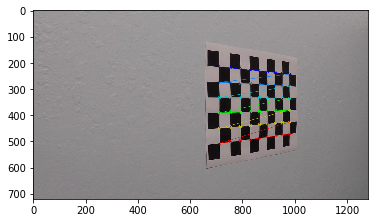

In [12]:
import glob
images = glob.glob('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/camera_cal/calibration*.jpg')

objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane
nx = 6 #enter the number of inside corners in x
ny = 9 #enter the number of inside corners in y


#Prepare object points like (0,0,0),(1,0,0) etc..
objp = np.zeros((6*9,3),np.float32)
#Third column will always be zero. No need to change. Need to populate x and y column. Use mgrid of numpy.
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)#x,y coordinate

#Now we have to create image points. For that we have to detect the corners of the board.

for fname in images:
    #print (fname)
    
    image = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    #If there is any corner point then append it to image point array.
    #Also add prepared obj points to object point array
    #These object points are same for for all of the calibration images as they represent  read chessboard
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        #Display these corner points on an image
        cv2.drawChessboardCorners(image, (9, 6), corners, ret)
        plt.imshow(image)


    

In [13]:
print (len(imgpoints))
print (len(objpoints))

17
17


In [14]:
#Calibration of camera using object points and image points. It retruns camera matrix and distortion coeff in mtx
#and dist variable resp.
#rvecs and tvecs containts position of camera in real world
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [15]:
#Now undistort an image and check it
img = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/camera_cal/calibration2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

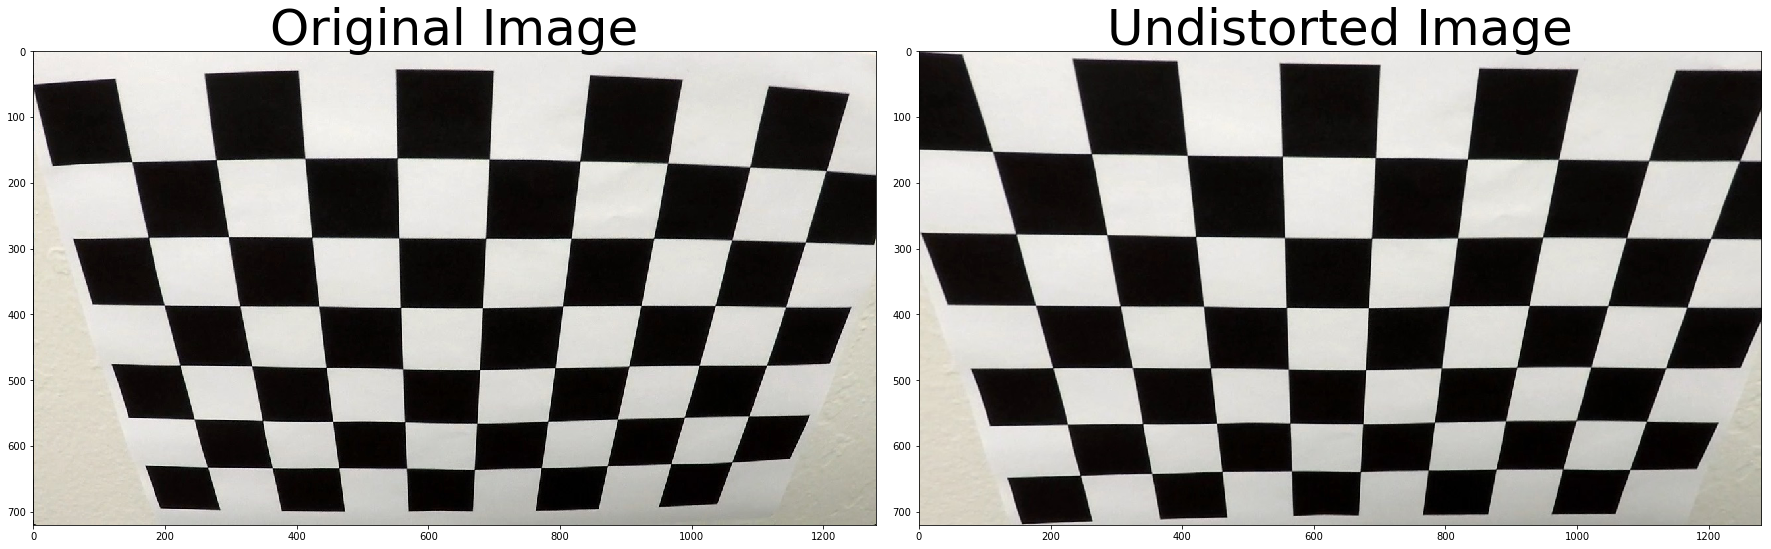

In [16]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [17]:
cv2.imwrite("Original.jpg",img)

True

In [18]:
cv2.imwrite("Undistorted.jpg",dst)

True

## PART 2: PIPELINE Functoins

In [37]:
#Undistort an image

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/640 # meters per pixel in x dimension


def undistort_image(img,mat,dist):
    return cv2.undistort(img,mat,dist,None,mat)

#Color and x gradient thresholding
def threshold_image(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    hsv1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    h_hsv_channel1 = hsv1[:,:,0]
    s_hsv_channel1 = hsv1[:,:,1]
    v_hsv_channel1 = hsv1[:,:,2]

    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx1 = cv2.Sobel(gray1, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx1 = np.absolute(sobelx1) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel1 = np.uint8(255*abs_sobelx1/np.max(abs_sobelx1))

    # Threshold x gradient
    #thresh_min1 = 24
    #thresh_max1 = 110
    #thresh_min1 = 40
    #thresh_max1 = 100
    thresh_min1 = 30
    thresh_max1 = 100
    
    sxbinary1 = np.zeros_like(scaled_sobel1)
    sxbinary1[(scaled_sobel1 >= thresh_min1) & (scaled_sobel1 <= thresh_max1)] = 1

    # Threshold color channel
    #s_thresh_min1 = 165
    #s_thresh_max1 = 254
    #s_thresh_min1 = 160
    #s_thresh_max1 = 254
    s_thresh_min1 = 220
    s_thresh_max1 = 254
    
    
    s_binary1 = np.zeros_like(s_channel)
    #s_binary1[(s_channel >= s_thresh_min1) & (s_channel <= s_thresh_max1)] = 1
    s_binary1[(r >= s_thresh_min1) & (r <= s_thresh_max1)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary1 = np.dstack(( np.zeros_like(sxbinary1), sxbinary1, s_binary1)) * 255

    # Combine the two binary thresholds
    combined_binary1 = np.zeros_like(sxbinary1)
    combined_binary1[(s_binary1 == 1) | (sxbinary1 == 1)] = 1
    
    return combined_binary1,color_binary1

#Perspective transformation
def transform_image(img):
    
    src_points = np.float32([[705,460],[1110,720],[205,720],[580,460]])
    dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])
    img_size = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points,src_points)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,Minv

#Find Region of Interest
def mask_image(img):
    vertices = np.array([[(100,720),(200,0), (1150, 0), (1200,720)]], dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    #plt.imshow(masked_image)
    return masked_image

#Use Histogram method to find lane lines
def find_histogram(img):
    histogram = np.sum(img[img.shape[0]//2 - 60:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    print (midpoint)

    leftx_base = np.argmax(histogram[:midpoint])
    print (leftx_base)

    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print (rightx_base)
    
    return histogram,midpoint,leftx_base,rightx_base


def find_lanes(img,out_img,leftx_base,rightx_base):
    #Choose the number of sliding windows
    nwindows = 9

    #Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    #Identify x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 78
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #CURVATURE
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')

    #Find the center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_cr[0]*yMax**2 + left_fit_cr[1]*yMax + left_fit_cr[2]
    lineRight = right_fit_cr[0]*yMax**2 + right_fit_cr[1]*yMax + right_fit_cr[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = vehicleCenter - lineMiddle


    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fitx,right_fitx,left_fit_cr,right_fit_cr,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty,left_curverad,right_curverad,diffFromVehicle

#Visulizing lane lines
def visualize_lane_lines(img,out_img,left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty):
    # Create an image to draw on and an image to show the selection window
    #margin = 100
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

#Merging with original image for final output image
def merged_image(img,original,Minv,left_fitx,right_fitx,ploty,left_curverad,right_curverad,diffFromVehicle):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)

    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 2
    fontColor = (255, 0, 0)
    cv2.putText(result, 'Left curvature is: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Right curvature is: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    #plt.imshow(result)
    return result
    
    


## PART 3 : Pipeline for an Image

(720, 1280, 3)


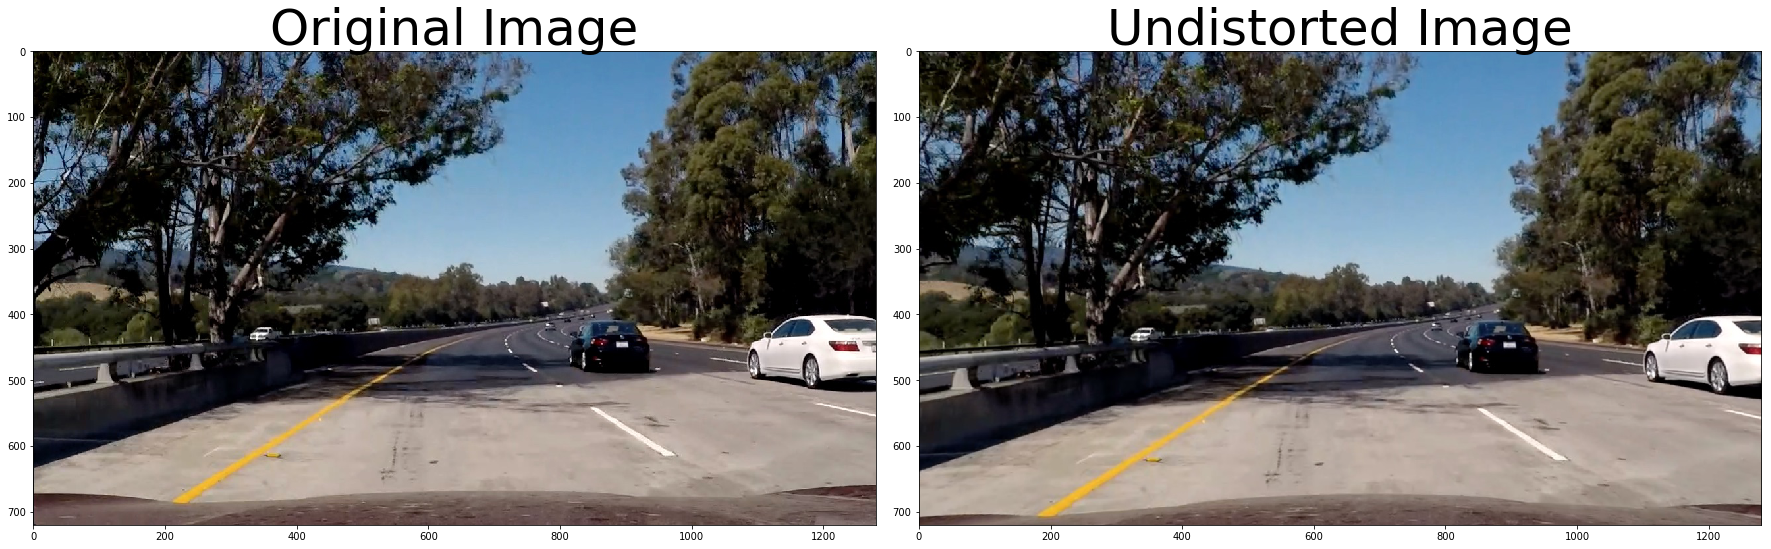

In [38]:
#test1 = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/test_images/test4.jpg')
test1 = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/test_images/test5.jpg')
print (test1.shape)


#test_dst = cv2.undistort(test1, mtx, dist, None, mtx)
test_dst = undistort_image(test1,mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

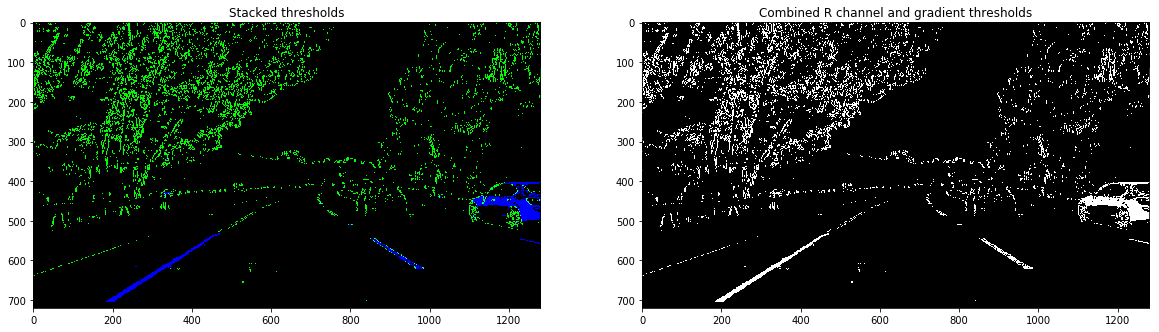

In [39]:

combined,color = threshold_image(test_dst)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color)
ax2.set_title('Combined R channel and gradient thresholds')
ax2.imshow(combined, cmap='gray')



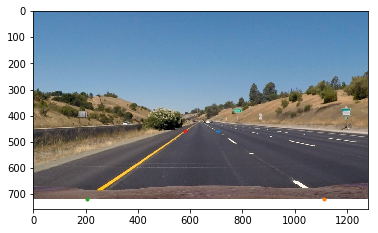

In [40]:
straight_image = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg')

plt.imshow(straight_image)
plt.plot(705,460,'.') #Top right
plt.plot(1110,720,'.') #Bottom right
plt.plot(205,720,'.') #Bottom left
plt.plot(580,460,'.') #Top left




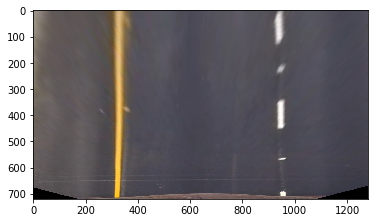

In [41]:
straight_image_dst = cv2.undistort(straight_image, mtx, dist, None, mtx)
src_points = np.float32([[705,460],[1110,720],[205,720],[580,460]])
##src_points = np.float32([[695,460],[1127,720],[203,720],[585,460]])
dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])
##dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])

img_size = (straight_image.shape[1],straight_image.shape[0])
M1 = cv2.getPerspectiveTransform(src_points, dst_points)
Minv1 = cv2.getPerspectiveTransform(dst_points,src_points)
straight_warped = cv2.warpPerspective(straight_image_dst, M1, img_size, flags=cv2.INTER_LINEAR)

plt.imshow(straight_warped)




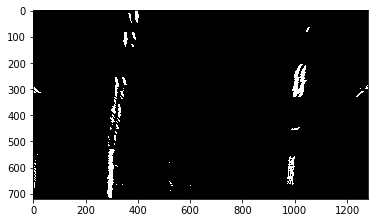

In [42]:
#Perspective Transformation
warped_image,Minv = transform_image(combined)
plt.imshow(warped_image,cmap='gray')



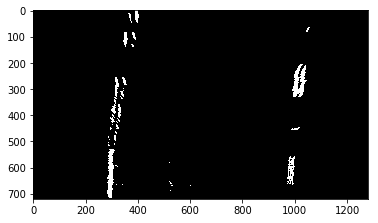

In [43]:
#Masking an image
masked_image = mask_image(warped_image)
plt.imshow(masked_image,cmap="gray")

640
300
991


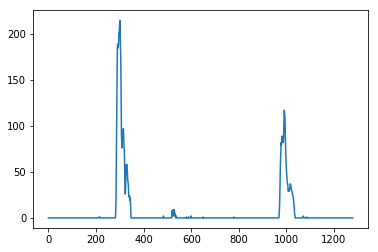

In [44]:
#Find Histogram
histogram_image,midpoint,leftx_base,rightx_base = find_histogram(masked_image)
plt.plot(histogram_image)

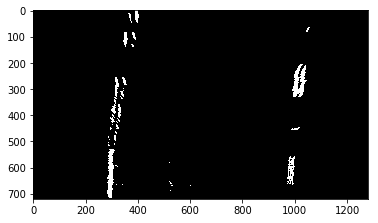

In [45]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((masked_image, masked_image, masked_image))*255

plt.imshow(out_img)



2822.31461426 4767.65595008
847.442083573 m 1428.93325298 m


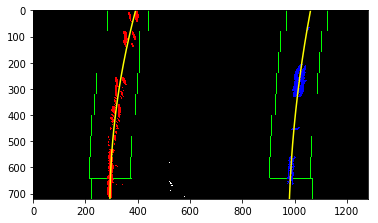

In [46]:
#Visualization of sliding window image
left_fitx,right_fitx,left_fit_cr,right_fit_cr,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty,left_curverad,right_curverad,diffFromVehicle = find_lanes(masked_image,out_img,leftx_base,rightx_base)

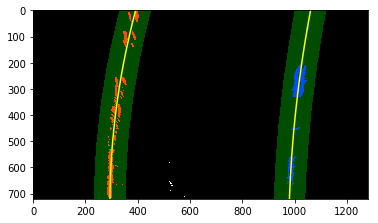

In [47]:

visualize_lane_lines(masked_image,out_img,left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty)

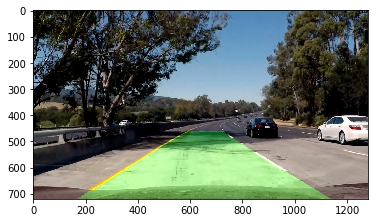

In [48]:
#Final output
final_image = merged_image(masked_image,test1,Minv,left_fitx,right_fitx,ploty,left_curverad,right_curverad,diffFromVehicle)

In [49]:
##Code to Store video in frames

#import cv2
#vidcap = cv2.VideoCapture('project_video.mp4')
#success,image = vidcap.read()
#count = 0
#success = True
#while success:
#    success,image = vidcap.read()
#    print('Read a new frame: ', success)
#    cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
#    count += 1

## PIPELINE for Video

In [50]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.left_fitx = None
        self.right_fitx = None
        self.left_fit_cr = None
        self.right_fit_cr = None
        self.radius_of_curvature = None        
        self.line_base_pos = None
        self.left_cureverad = None
        self.right_curverad = None
leftLane = Line()
rightLane = Line()
    
def process_image(img):
    undist = undistort_image(img,mtx,dist)
    combined,color = threshold_image(undist)
    
    warped_image,Minv = transform_image(combined)
    masked_image = mask_image(warped_image)
    histogram_image,midpoint,leftx_base,rightx_base = find_histogram(masked_image)  
    out_img = np.dstack((warped_image, warped_image, warped_image))*255
    left_fitx,right_fitx,left_fit_cr,right_fit_cr,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty,left_curverad,right_curverad,diffFromVehicle = find_lanes(warped_image,out_img,leftx_base,rightx_base)
    if left_curverad > 10000:
        left_fitx = leftLane.left_fitx
        left_fit_cr = leftLane.left_fit_cr
        left_curverad = leftLane.left_curverad
    else:
        leftLane.left_fitx = left_fitx
        leftLane.left_fit_cr = left_fit_cr
        leftLane.left_curverad = left_curverad

    if right_curverad > 10000:
        right_fitx = rightLane.right_fitx
        right_fit_cr = rightLane.right_fit_cr
        right_curverad = rightLane.right_curverad
    else:
        rightLane.right_fitx = right_fitx
        rightLane.right_fit_cr = right_fit_cr
        rightLane.right_curverad = right_curverad
            
    final_result = merged_image(warped_image,undist,Minv,left_fitx,right_fitx,ploty,left_curverad,right_curverad,diffFromVehicle)
    return final_result
    
    
    

In [51]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

640
364
1022
1932.49596388 2600.27290127
577.589062722 m 779.681918789 m
[MoviePy] >>>> Building video output_video/project_video_output_trial11_red_channel_all.mp4
[MoviePy] Writing video output_video/project_video_output_trial11_red_channel_all.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

640
364
1022
1932.49596388 2600.27290127
577.589062722 m 779.681918789 m


  0%|          | 1/1261 [00:00<03:06,  6.76it/s]

640
366
1001
1860.24526534 2889.74600293
555.394702296 m 864.313496415 m


  0%|          | 2/1261 [00:00<03:04,  6.83it/s]

640
367
1004
1860.40216208 1922.17642284
555.638531495 m 577.108345226 m


  0%|          | 4/1261 [00:00<02:56,  7.14it/s]

640
368
972
1871.87322469 1928.73312381
559.603944339 m 578.621814349 m
640
369
958
2112.11984073 2106.47481691
633.746002868 m 630.845734296 m


  0%|          | 5/1261 [00:00<02:57,  7.06it/s]

640
367
969
2036.48034568 2684.24951575
610.926766413 m 798.38039364 m


  0%|          | 6/1261 [00:00<02:56,  7.10it/s]

640
368
969
2012.36626044 3170.97150222
603.83213796 m 939.206684592 m


  1%|          | 7/1261 [00:00<02:55,  7.14it/s]

640
374
970
2054.70498542 76773.6854962
616.832109524 m 21134.4602771 m


  1%|          | 8/1261 [00:01<02:52,  7.24it/s]

640
371
976
2132.80878748 14107.1251922
640.477089457 m 3825.10164632 m


  1%|          | 9/1261 [00:01<02:52,  7.25it/s]

640
372
980
2302.16348175 72021.5762245
691.21400585 m 19972.5586074 m


  1%|          | 10/1261 [00:01<02:52,  7.25it/s]

640
369
1002
2455.73470843 7804.55495026
736.9388231 m 2238.58513542 m


  1%|          | 11/1261 [00:01<02:53,  7.22it/s]

640
368
1012
2663.21897551 6628.41116106
797.329226004 m 1935.0576578 m


  1%|          | 12/1261 [00:01<02:54,  7.17it/s]

640
369
1001
2723.57570828 7769.70917395
815.290226573 m 2249.93060045 m


  1%|          | 13/1261 [00:01<02:54,  7.16it/s]

640
363
996
2918.22863355 6982.40838233
872.48555751 m 2025.57071698 m


  1%|          | 14/1261 [00:01<02:52,  7.21it/s]

640
368
1003
2381.52795837 3103.96993572
714.762539209 m 914.990215745 m


  1%|          | 15/1261 [00:02<02:52,  7.22it/s]

640
365
1008
3015.45645227 2254.38566426
902.402112623 m 668.677071149 m


  1%|▏         | 16/1261 [00:02<02:51,  7.27it/s]

640
367
941
2930.07012859 2622.77583113
876.877911388 m 774.702652451 m


  1%|▏         | 17/1261 [00:02<02:52,  7.19it/s]

640
370
943
2796.59934062 3517.29009226
837.327928541 m 1025.24811071 m


  1%|▏         | 18/1261 [00:02<02:50,  7.29it/s]

640
369
962
3234.65000922 3858.05808762
966.26809607 m 1124.93479785 m


  2%|▏         | 19/1261 [00:02<02:49,  7.31it/s]

640
369
970
3577.08019047 4812.72034239
1065.66029192 m 1397.8486691 m


  2%|▏         | 20/1261 [00:02<02:49,  7.32it/s]

640
341
979
3517.72785131 9217.4061397
1048.29013433 m 2633.11941809 m


  2%|▏         | 21/1261 [00:02<02:49,  7.32it/s]

640
340
988
3742.40947368 9909.70351835
1113.05286606 m 2848.3495375 m


  2%|▏         | 22/1261 [00:03<02:55,  7.05it/s]

640
339
994
3829.51678825 8292.76351275
1138.95104778 m 2408.77837969 m


  2%|▏         | 23/1261 [00:03<02:55,  7.04it/s]

640
339
998
3303.20212679 3691.51906324
986.823202478 m 1092.98068947 m


  2%|▏         | 24/1261 [00:03<02:56,  7.02it/s]

640
340
1000
3318.63654751 2690.44726982
991.888902815 m 802.571009251 m


  2%|▏         | 25/1261 [00:03<02:53,  7.13it/s]

640
343
993
3321.64464884 3064.99371597
993.417293896 m 913.986969055 m


  2%|▏         | 26/1261 [00:03<02:54,  7.10it/s]

640
340
990
2668.27395924 4193.10264707
800.695754837 m 1241.17283624 m


  2%|▏         | 27/1261 [00:03<02:52,  7.17it/s]

640
331
1001
2549.33945113 3724.42956738
765.342027716 m 1110.66311242 m


  2%|▏         | 28/1261 [00:03<02:50,  7.22it/s]

640
336
1000
2666.48656118 3217.23109037
800.447397455 m 960.529573766 m


  2%|▏         | 29/1261 [00:04<02:49,  7.28it/s]

640
342
1015
2507.08436806 1962.78224612
752.811922838 m 588.855788328 m


  2%|▏         | 30/1261 [00:04<02:50,  7.22it/s]

640
346
953
2280.05949386 2324.82158195
684.635991024 m 694.199216487 m


  2%|▏         | 31/1261 [00:04<02:50,  7.23it/s]

640
350
952
2120.65379948 2780.74694081
636.385523572 m 822.818936065 m


  3%|▎         | 32/1261 [00:04<02:49,  7.26it/s]

640
350
971
2165.28129469 4059.4196065
649.912700593 m 1187.17479503 m


  3%|▎         | 33/1261 [00:04<02:48,  7.31it/s]

640
352
963
2084.27726278 30722.4044015
625.327980019 m 8528.55843925 m


  3%|▎         | 34/1261 [00:04<02:48,  7.28it/s]

640
353
990
1981.21924185 9996.16171106
593.985990929 m 2829.60021757 m


  3%|▎         | 35/1261 [00:04<02:50,  7.18it/s]

640
355
969
1930.91099146 3037.62253799
578.724305979 m 894.764796372 m


  3%|▎         | 36/1261 [00:04<02:49,  7.23it/s]

640
357
996
1780.48816206 2946.97182902
532.751607059 m 869.004960706 m


  3%|▎         | 37/1261 [00:05<02:49,  7.22it/s]

640
358
988
1708.31527211 3859.56528565
510.691916648 m 1123.22940426 m


  3%|▎         | 38/1261 [00:05<02:50,  7.17it/s]

640
360
984
1644.02099617 1935.80784396
490.943411501 m 577.488665993 m


  3%|▎         | 39/1261 [00:05<02:50,  7.17it/s]

640
360
1006
1637.06343793 1599.56813718
488.987710702 m 479.487011165 m


  3%|▎         | 40/1261 [00:05<02:48,  7.27it/s]

640
360
989
1588.00397338 1908.7223309
474.0844817 m 569.197331941 m


  3%|▎         | 41/1261 [00:05<02:49,  7.18it/s]

640
361
941
1550.59964623 2189.70086619
463.067492688 m 650.263208572 m


  3%|▎         | 42/1261 [00:05<02:48,  7.22it/s]

640
361
944
1624.51443307 1956.10454348
486.529391991 m 582.980491894 m


  3%|▎         | 43/1261 [00:05<02:51,  7.10it/s]

640
362
950
1699.64729728 2196.83643166
509.786974447 m 653.835352814 m


  3%|▎         | 44/1261 [00:06<02:52,  7.07it/s]

640
361
956
1819.4544504 2611.15824949
546.27247525 m 773.013217887 m


  4%|▎         | 45/1261 [00:06<02:51,  7.07it/s]

640
361
960
1876.1765365 5653.68765061
563.412226265 m 1616.676176 m


  4%|▎         | 46/1261 [00:06<02:52,  7.05it/s]

640
358
990
1951.1996364 5014.8482969
585.876644456 m 1446.48934372 m


  4%|▎         | 47/1261 [00:06<02:51,  7.06it/s]

640
361
990
2018.54280539 6475.13248936
605.960024026 m 1848.51515498 m


  4%|▍         | 48/1261 [00:06<02:54,  6.97it/s]

640
358
998
2175.84021831 5563.55971381
652.573538658 m 1608.99694841 m


  4%|▍         | 49/1261 [00:06<02:53,  6.97it/s]

640
361
1002
2348.83569419 2372.23965925
703.230185533 m 705.81205341 m


  4%|▍         | 50/1261 [00:06<02:52,  7.04it/s]

640
361
988
2612.8619101 3286.13985049
780.274445486 m 966.356810709 m


  4%|▍         | 51/1261 [00:07<02:51,  7.06it/s]

640
362
1004
2704.25156142 3538.41762226
806.821600338 m 1035.15504606 m


  4%|▍         | 52/1261 [00:07<02:52,  7.02it/s]

640
363
1007
2537.07179919 2036.94873487
758.745072087 m 606.986943141 m


  4%|▍         | 53/1261 [00:07<02:52,  7.01it/s]

640
363
1010
2767.92664117 1973.18939387
826.231830181 m 587.238830448 m


  4%|▍         | 54/1261 [00:07<02:50,  7.06it/s]

640
356
933
3274.38983466 1963.71393074
972.541259407 m 585.966458031 m


  4%|▍         | 55/1261 [00:07<02:54,  6.90it/s]

640
355
941
3733.28048172 2223.95386843
1105.65214204 m 660.363058616 m


  4%|▍         | 56/1261 [00:07<02:54,  6.89it/s]

640
355
953
3715.2686497 2572.93590161
1101.25897013 m 758.24289664 m


  5%|▍         | 57/1261 [00:07<02:53,  6.94it/s]

640
330
953
3831.45256486 4510.01322178
1135.79108177 m 1293.87278884 m


  5%|▍         | 58/1261 [00:08<02:54,  6.91it/s]

640
340
955
3809.8300347 12271.5108374
1132.21834396 m 3355.90738258 m


  5%|▍         | 59/1261 [00:08<02:51,  6.99it/s]

640
341
958
3276.85023174 3820.31563244
978.502188696 m 1092.13123817 m


  5%|▍         | 60/1261 [00:08<02:53,  6.92it/s]

640
343
976
2840.07651889 5389.15807232
850.633409552 m 1518.41225984 m


  5%|▍         | 61/1261 [00:08<02:51,  7.01it/s]

640
343
966
2595.83168159 4107.58609759
778.739888476 m 1168.9487406 m


  5%|▍         | 62/1261 [00:08<02:53,  6.91it/s]

640
345
975
2541.37127218 3623.82117253
762.663019041 m 1042.92997859 m


  5%|▍         | 63/1261 [00:08<03:13,  6.21it/s]

640
347
986


  5%|▌         | 64/1261 [00:09<03:04,  6.48it/s]

2395.25170367 2097.80985369
719.251436204 m 619.04401904 m
640
348
992
2226.65248145 2485.00870177
668.617420863 m 730.77239817 m


  5%|▌         | 66/1261 [00:09<02:58,  6.69it/s]

640
346
995
2238.23261103 2705.09258125
672.036077716 m 791.088272902 m
640
348
914
2177.28629207 2716.69293775
653.640164967 m 798.775823386 m


  5%|▌         | 68/1261 [00:09<03:02,  6.55it/s]

640
344
923
2454.4641198 3131.00188278
737.027096167 m 917.85181694 m
640
349
924
2415.60363551 4051.42839831
725.401500541 m 1174.55996533 m


  6%|▌         | 70/1261 [00:09<02:56,  6.76it/s]

640
346
931
2534.8626941 5661.34610823
761.07194903 m 1630.25866218 m
640
347
936
2660.82103851 9058.34225963
798.686294788 m 2562.2357946 m


  6%|▌         | 72/1261 [00:10<02:52,  6.91it/s]

640
346
941
2915.45203322 3241.31563424
874.284456584 m 955.194341981 m
640
345
944
3276.89668398 2561.11973579
981.252125144 m 762.259358581 m


  6%|▌         | 74/1261 [00:10<02:52,  6.87it/s]

640
345
949
3587.35127746 3561.77620257
1073.05053779 m 1048.39388706 m
640
343
956
4364.43320353 4014.4132098
1300.58052064 m 1181.77818923 m


  6%|▌         | 76/1261 [00:10<02:50,  6.95it/s]

640
345
960
4558.59329163 3177.6714576
1358.60575107 m 941.471521391 m
640
333
968
5100.04221798 3379.69602408
1516.22124104 m 1004.53969508 m


  6%|▌         | 78/1261 [00:11<02:50,  6.92it/s]

640
325
972
6182.36478836 2060.54629077
1832.61964521 m 618.447073938 m
640
325
974
5773.47930017 1760.82798579
1714.55080257 m 528.754630551 m


  6%|▋         | 80/1261 [00:11<02:51,  6.89it/s]

640
322
978
5734.15059632 1873.20341065
1705.12666992 m 562.499086549 m
640
322
931
6457.87222653 2223.68431644
1918.55885734 m 666.123188816 m


  7%|▋         | 82/1261 [00:11<02:52,  6.83it/s]

640
322
934
7304.10869415 2350.10362655
2169.11133398 m 703.53930311 m
640
319
941
5868.54624532 3092.70476601
1748.55939837 m 919.231859191 m


  7%|▋         | 84/1261 [00:11<02:49,  6.96it/s]

640
315
951
5550.78717943 4678.61388695
1654.00538228 m 1379.47048744 m
640
316
956
4994.89282675 10043.521457
1491.87280801 m 2911.06811333 m


  7%|▋         | 86/1261 [00:12<02:51,  6.86it/s]

640
319
959
4154.50844441 23544.4735398
1244.34794038 m 6762.46453624 m
640
326
959
3264.13639193 3253.2351694
980.172072963 m 964.315846347 m


  7%|▋         | 88/1261 [00:12<02:49,  6.94it/s]

640
329
959
2813.00016061 7499.60090457
844.362106807 m 2170.72049834 m
640
332
969
2544.37341426 3197.99881099
762.596209677 m 945.43250391 m


  7%|▋         | 90/1261 [00:12<03:00,  6.48it/s]

640
334
962
2317.6020278 2092.1436361
692.937921469 m 624.382130551 m
640
332
969
2216.09725866 2274.63139019
661.960897759 m 678.22629859 m


  7%|▋         | 92/1261 [00:13<03:18,  5.90it/s]

640
334
973
2188.42294054 2522.8803354
653.838622541 m 750.951013616 m
640
335
920
2176.79599925

  7%|▋         | 94/1261 [00:13<03:28,  5.60it/s]

 2823.55460893
650.473841824 m 836.655083213 m
640
337
924
2200.99198764 3266.21239121
657.935711789 m 963.229541528 m
640
336
931


  8%|▊         | 95/1261 [00:13<03:22,  5.75it/s]

2271.57308237 3476.88966645
679.974924677 m 1027.23876601 m
640
336
935
2320.7186909 5662.84960767
695.178218866 m 1644.78042307 m


  8%|▊         | 97/1261 [00:14<03:25,  5.67it/s]

640
337
952
2339.39237864 5410.80867603
701.142208567 m 1576.97743263 m
640
337
966
2392.65922582 3066.30242862
717.488444399 m 913.458802807 m


  8%|▊         | 99/1261 [00:14<03:17,  5.88it/s]

640
339
950
2476.34679613 3231.9529372
742.895255062 m 960.04457057 m
640
339
956
2502.21609896 3129.68341506
750.847409976 m 932.596534631 m


  8%|▊         | 101/1261 [00:14<03:16,  5.90it/s]

640
340
958
2435.09833109 2968.4457443
730.498292469 m 885.375283279 m
640
342
961
2418.25996238 2341.45629097
725.224437954 m 701.223409707 m


  8%|▊         | 103/1261 [00:15<03:02,  6.35it/s]

640
342
983
2381.0960499 1858.00916505
713.99111128 m 557.899621868 m
640
344
969
2371.22118394 1958.943066
711.01235876 m 587.928129024 m


  8%|▊         | 105/1261 [00:15<03:04,  6.25it/s]

640
343
990
2514.37184962 2130.66887112
754.619901608 m 639.44874058 m
640
343
960
2687.63047356 2297.02957017
807.034546109 m 689.320699717 m


  8%|▊         | 107/1261 [00:15<03:01,  6.34it/s]

640
344
967
2585.1446975 2464.08364368
776.204231634 m 739.308991019 m
640
346
969
2406.90379258 2707.02855403
722.261022007 m 810.228709958 m


  9%|▊         | 109/1261 [00:16<02:55,  6.58it/s]

640
346
974
2446.22650981 6533.10228112
734.122104543 m 1906.43971827 m
640
349
979
2449.3535833 8795.03717361
734.968880051 m 2558.19040972 m


  9%|▉         | 111/1261 [00:16<02:56,  6.51it/s]

640
347
984
2341.83004984 6488.87713945
702.487998052 m 1901.14371379 m
640
346
972
2490.52223675 4368.61024963
747.658658645 m 1298.83692402 m


  9%|▉         | 113/1261 [00:16<02:52,  6.65it/s]

640
349
973
2245.78515804 2833.81559892
673.351703598 m 847.878447069 m
640
349
978
2197.35938063 2993.35285546
658.518963992 m 894.214845665 m


  9%|▉         | 115/1261 [00:16<02:54,  6.58it/s]

640
350
980
1969.16484843 2103.21505701
588.513284696 m 631.011957882 m
640
351
1000
1952.37361137 1597.65168253
583.359034302 m 479.656138667 m


  9%|▉         | 117/1261 [00:17<02:50,  6.70it/s]

640
351
985
1957.62723065 1804.57652318
585.261036943 m 541.787564763 m
640
352
937
2063.81305971 1901.01598803
618.295637327 m 570.331554776 m


  9%|▉         | 119/1261 [00:17<02:47,  6.82it/s]

640
353
941
2142.99739505 1941.21354603
642.467857271 m 582.020993944 m
640
355
943
2021.86321659 2194.96540839
605.574600298 m 655.067438222 m


 10%|▉         | 121/1261 [00:17<02:46,  6.84it/s]

640
356
952
2072.09921532 2539.76522061
621.15561004 m 754.926353194 m
640
357
958
1968.85552018 2800.51297047
589.809962581 m 826.857907049 m


 10%|▉         | 123/1261 [00:18<02:45,  6.86it/s]

640
358
961
1945.96099629 1984.89312103
582.82936706 m 593.352372334 m
640
359
966
1905.28068003 2414.65335756
570.399561005 m 716.269479441 m


 10%|▉         | 125/1261 [00:18<02:46,  6.82it/s]

640
361
982
1869.95992922 2382.90875181
559.757081923 m 706.364398171 m
640
360
994
2052.99071223 3233.44095985
615.943259607 m 951.65234233 m


 10%|█         | 127/1261 [00:18<02:45,  6.84it/s]

640
361
982
1971.27585996 1564.52158768
591.09627342 m 469.617724816 m
640
362
1005
1944.68585702 1679.20634296
583.068682583 m 503.736855324 m


 10%|█         | 129/1261 [00:18<02:43,  6.92it/s]

640
364
989
1859.64667167 1904.67522939
557.114665523 m 567.939653191 m
640
364
991
2031.87557771 2026.85772967
609.745816494 m 603.651949173 m


 10%|█         | 131/1261 [00:19<02:44,  6.86it/s]

640
365
938
2183.38149547 2185.1353049
655.635989234 m 648.664407184 m
640
365
949
2163.47281732 2412.81339996
649.634607729 m 711.731048892 m


 11%|█         | 133/1261 [00:19<02:44,  6.87it/s]

640
366
957
2259.2984664 2489.59854883
678.467614065 m 735.606149063 m
640
368
967
2214.62100867 2891.22692148
665.045716783 m 843.603833316 m


 11%|█         | 135/1261 [00:19<02:47,  6.72it/s]

640
369
969
2314.57666072 2330.86736319
695.050221971 m 690.471602028 m
640
370
974
2225.49311272 3308.23387775
668.315566617 m 966.645333684 m


 11%|█         | 137/1261 [00:20<02:47,  6.72it/s]

640
367
992
2384.93111513 3924.70296305
716.085114269 m 1143.77337438 m
640
366
1002
2424.10152334 4567.21072669
727.812963234 m 1332.68385406 m


 11%|█         | 139/1261 [00:20<02:45,  6.77it/s]

640
366
988
2374.06120218 7388.28994912
712.89134704 m 2126.524605 m
640
366
995
2493.26092328 6944.84475141
748.521704786 m 2021.0996876 m


 11%|█         | 141/1261 [00:20<02:46,  6.73it/s]

640
366
1015
2441.07426371 2864.37182932
732.988089123 m 851.039150315 m
640
366
1017
2478.59523938 2388.45039282
744.278662207 m 712.616278723 m


 11%|█▏        | 143/1261 [00:21<02:48,  6.64it/s]

640
354
946
2865.67455021 2814.13750911
859.773634219 m 833.526772777 m
640
356
946
2668.13468731 3213.18037327
800.989293786 m 948.776418011 m


 11%|█▏        | 145/1261 [00:21<02:46,  6.71it/s]

640
358
953
2865.53275521 3771.50507623
859.934753144 m 1109.0113354 m
640
362
960
3040.95674603 5496.56044522
912.48009919 m 1593.05172251 m


 12%|█▏        | 147/1261 [00:21<02:45,  6.73it/s]

640
361
961
2969.00661125 7677.31010178
890.950164767 m 2210.56082823 m
640
365
964
2902.39173958 2868.12341155
871.394702801 m 847.047440046 m


 12%|█▏        | 149/1261 [00:21<02:45,  6.73it/s]

640
365
962
2759.97071562 2942.23845078
828.809685647 m 868.635097243 m
640
365
972
2887.9421462 3337.41691707
867.111032264 m 985.214580363 m


 12%|█▏        | 151/1261 [00:22<02:43,  6.78it/s]

640
360
976
2959.8448527 2518.01776768
888.586588059 m 751.198719478 m
640
360
985
2948.46952339 1945.14479081
885.186761599 m 583.668307834 m


 12%|█▏        | 153/1261 [00:22<02:42,  6.81it/s]

640
362
988
2777.7397558 1700.01233946
834.146118 m 510.277457288 m
640
362
992
2991.05945341 1848.55623383
897.89257435 m 554.634886352 m


 12%|█▏        | 155/1261 [00:22<02:40,  6.87it/s]

640
351
1013
2904.31960363 2122.13488869
871.695766097 m 635.482413388 m
640
352
970
2913.63875939 2312.9475446
874.516841591 m 691.178031816 m


 12%|█▏        | 157/1261 [00:23<02:43,  6.74it/s]

640
350
948
2892.0870813 2628.65464661
868.018665848 m 782.559223036 m
640
352
965
2794.50483762 3228.58418265
839.047580295 m 951.69076736 m


 13%|█▎        | 159/1261 [00:23<02:48,  6.54it/s]

640
349
958
2794.18441645 8796.09659789
838.863136102 m 2492.02967334 m
640
349
970
2622.78085932 6458.54076341
787.58955479 m 1843.2058636 m


 13%|█▎        | 161/1261 [00:23<02:47,  6.58it/s]

640
348
986
2628.68789925 5615.73193148
789.257153178 m 1622.30464072 m
640
351
974
2589.82441733 5018.38656444
777.524538782 m 1459.39635418 m


 13%|█▎        | 163/1261 [00:24<02:47,  6.55it/s]

640
349
988
2640.98988562 8294.51510957
792.732782872 m 2391.73829406 m
640
349
989
2463.46040469 10167.3939787
739.732699219 m 2902.51197211 m


 13%|█▎        | 165/1261 [00:24<02:54,  6.30it/s]

640
351
988
2249.88294875 2270.71718074
675.544954885 m 674.848256521 m
640
351
986
2315.22564887 2451.72449906
695.262643234 m 727.057987637 m


 13%|█▎        | 167/1261 [00:24<03:01,  6.04it/s]

640
351
1004
2315.74989298 2721.25576298
695.409204748 m 800.519068781 m
640
346
930
2548.16229251 2588.98929225
764.70280501 m 768.787147429 m


 13%|█▎        | 169/1261 [00:24<02:50,  6.39it/s]

640
349
938
2708.84677163 2890.69789069
812.151847006 m 855.298756023 m
640
342
945
3070.30896279 3222.96027511
918.553658748 m 954.463365651 m


 14%|█▎        | 171/1261 [00:25<02:48,  6.47it/s]

640
345
951
3195.61387253 3322.6599642
955.254771277 m 984.216822139 m
640
344
954
3242.13038456 3154.53055272
968.704936939 m 935.817552538 m


 14%|█▎        | 173/1261 [00:25<02:43,  6.65it/s]

640
343
977
3219.00037443 1831.15573674
962.633185566 m 549.848073415 m
640
345
974
2835.10466057 1604.36969093
849.877934555 m 481.792069505 m


 14%|█▍        | 175/1261 [00:25<02:41,  6.73it/s]

640
342
979
2871.94762996 1271.88276604
861.062453047 m 381.116168577 m
640
341
964
2665.38382768 1048.26928641
799.893778668 m 311.105261103 m


 14%|█▍        | 177/1261 [00:26<02:39,  6.78it/s]

640
327
973
2715.59228006 1129.46327226
814.674216452 m 336.157066182 m
640
337
997
2652.88447043 1163.40954535
796.083017899 m 347.321846506 m


 14%|█▍        | 179/1261 [00:26<02:39,  6.79it/s]

640
329
1002
2685.56143875 1301.71256748
805.977846151 m 390.525629469 m
640
329
988
2644.71393978 1404.82164579
793.766180316 m 421.780484553 m


 14%|█▍        | 181/1261 [00:26<02:39,  6.75it/s]

640
337
942
2316.28278996 1482.20123992
695.562119922 m 444.922229625 m
640
337
958
2253.03468391 1595.9647787
676.467153155 m 478.753707512 m


 15%|█▍        | 183/1261 [00:27<02:40,  6.72it/s]

640
340
962
1962.03722089 1760.87857083
587.865262923 m 525.807945506 m
640
339
965
1843.08482286 2051.89992621
551.030755828 m 604.287497138 m


 15%|█▍        | 185/1261 [00:27<02:39,  6.75it/s]

640
339
963
1751.74187426 1985.94070945
522.500113921 m 584.680865468 m
640
343
974
1591.64010579 1563.16205594
471.870382322 m 463.376813883 m


 15%|█▍        | 187/1261 [00:27<02:38,  6.78it/s]

640
343
979
1597.45306633 1397.22309666
473.870962065 m 416.770975325 m
640
344
978
1515.51963846 1837.57991329
448.290125224 m 536.790991625 m


 15%|█▍        | 189/1261 [00:27<02:38,  6.75it/s]

640
346
977
1525.21155545 1985.90683871
451.930120545 m 578.788904496 m
640
348
1000
1575.13877137 1830.49262248
468.216805483 m 535.94211107 m


 15%|█▌        | 191/1261 [00:28<02:39,  6.70it/s]

640
351
909
1533.51124178 1904.05368173
455.50652444 m 555.326513827 m
640
352
917
1736.81409473 2094.28875127
519.558524232 m 611.764527009 m


 15%|█▌        | 193/1261 [00:28<02:39,  6.70it/s]

640
355
925
1760.5253942 1900.76568834
527.189230897 m 557.948495298 m
640
357
935
1815.87321733 2001.20793382
544.251024652 m 585.406845749 m


 15%|█▌        | 195/1261 [00:28<02:40,  6.64it/s]

640
358
943
1832.56121215 1910.14365033
549.470002126 m 560.898993011 m
640
356
961
2153.45267029 2592.28800044
646.678523259 m 758.002374769 m


 16%|█▌        | 197/1261 [00:29<02:39,  6.69it/s]

640
353
965
2221.91596873 4744.34544966
667.049553 m 1365.52617569 m
640
349
990
2376.11483935 9264.57168362
712.681696086 m 2652.73904156 m


 16%|█▌        | 199/1261 [00:29<02:39,  6.65it/s]

640
333
996
2637.14993687 7706.66456608
788.940152582 m 2245.31599634 m
640
333
1001
2759.63985335 4994.06425847
825.106424441 m 1467.57757847 m


 16%|█▌        | 201/1261 [00:29<02:39,  6.64it/s]

640
332
991
2926.3625699 2730.42556994
874.259044371 m 816.140220043 m
640
336
1007
2675.57328156 3815.16367878
801.430338952 m 1126.13903862 m


 16%|█▌        | 203/1261 [00:30<02:39,  6.62it/s]

640
341
1006
2527.63130565 3207.70080944
758.102412461 m 949.303666819 m
640
340
1009
2609.99304217 1882.07987782
782.532627404 m 563.689867077 m


 16%|█▋        | 205/1261 [00:30<02:38,  6.68it/s]

640
341
935
2563.62193642 2087.84179949
768.984683388 m 622.496652239 m
640
342
946
2361.60714733 2228.54054175
708.925032346 m 661.758528433 m


 16%|█▋        | 207/1261 [00:30<02:35,  6.77it/s]

640
345
947
2266.1195154 2340.61224372
680.503288325 m 688.884156562 m
640
346
944
2210.21364371 2241.63396198
663.720171788 m 657.414913827 m


 17%|█▋        | 209/1261 [00:30<02:36,  6.74it/s]

640
346
962
2158.55096128 2695.76353743
648.2000532 m 784.716271457 m
640
344
960
2166.55788942 2577.84950725
650.616950062 m 757.874053588 m


 17%|█▋        | 211/1261 [00:31<02:35,  6.75it/s]

640
342
984
2269.17802801 2016.97070956
681.314163817 m 602.780138059 m
640
343
989
2180.65021112 2701.08593169
654.834983711 m 796.12159135 m


 17%|█▋        | 213/1261 [00:31<02:37,  6.65it/s]

640
341
977
2066.38237492 3221.1010198
620.519371285 m 943.865578791 m
640
337
980
2015.57322398 3092.4204517
605.206997687 m 905.189287073 m


 17%|█▋        | 215/1261 [00:31<02:37,  6.63it/s]

640
340
997
1861.08283164 1980.48721436
558.503005296 m 589.192003172 m
640
335
1001
1861.43729749 1936.55590638
558.691966657 m 576.130071345 m


 17%|█▋        | 217/1261 [00:32<02:38,  6.59it/s]

640
340
918
1908.08164817 2312.02342767
572.931178102 m 684.717943256 m
640
339
927
2086.78420027 2406.32500231
626.543567292 m 712.363069965 m


 17%|█▋        | 219/1261 [00:32<02:39,  6.55it/s]

640
339
934
2118.45735538 3147.69833078
636.01079875 m 916.375709198 m
640
337
939
2275.25210128 4465.98661549
682.338646862 m 1287.41480804 m


 18%|█▊        | 221/1261 [00:32<02:36,  6.65it/s]

640
338
950
2340.96041517 31263.3279815
701.48201383 m 8548.22026594 m
640
337
960
2438.13606718 14297.846933
730.044621978 m 3989.21173445 m


 18%|█▊        | 223/1261 [00:33<02:39,  6.49it/s]

640
339
965
2635.94688612 6335.92584517
787.806685178 m 1813.29495308 m
640
336
965
2553.87630354 5032.9881442
764.352452489 m 1443.46370057 m


 18%|█▊        | 225/1261 [00:33<02:37,  6.58it/s]

640
335
966
2497.56897522 5375.14739849
747.763385789 m 1544.56054883 m
640
334
968
2282.76485439 2600.37061518
684.902617461 m 766.422982147 m


 18%|█▊        | 227/1261 [00:33<02:36,  6.62it/s]

640
336
979
2341.24096457 2247.19793006
702.140359204 m 666.192779919 m
640
335
983
2508.65099903 2589.63297053
751.510606137 m 765.128185108 m


 18%|█▊        | 229/1261 [00:33<02:35,  6.63it/s]

640
335
982
2711.68696687 2875.14683271
810.873848957 m 847.358310475 m
640
330
915
2884.92928483 2739.21547242
861.096674436 m 812.283486105 m


 18%|█▊        | 231/1261 [00:34<02:33,  6.72it/s]

640
329
918
3113.03284517 2960.02381695
928.18584786 m 873.57085689 m
640
315
922
3353.5594573 3121.39107921
997.556929097 m 923.246715887 m


 18%|█▊        | 233/1261 [00:34<02:31,  6.77it/s]

640
328
936
3624.0401806 3852.22197662
1076.52373115 m 1129.42569007 m
640
308
934
3646.427673 3005.10785267
1083.48293647 m 889.445723904 m


 19%|█▊        | 235/1261 [00:34<02:31,  6.77it/s]

640
316
946
3769.1131647 2448.29498253
1119.89081486 m 729.144705248 m
640
323
946
3240.35168694 2659.5982384
967.346053822 m 785.146290485 m


 19%|█▉        | 237/1261 [00:35<02:31,  6.75it/s]

640
321
951
3059.70764287 2360.21120974
914.606111762 m 700.628965066 m
640
321
964
2681.69678655 1540.99440421
803.967162971 m 462.344923973 m


 19%|█▉        | 239/1261 [00:35<02:34,  6.64it/s]

640
316
951
2633.07495545 1607.79696954
789.906927144 m 481.513820974 m
640
308
969
2591.63455629 1855.83306057
777.657000253 m 553.502772258 m


 19%|█▉        | 241/1261 [00:35<02:33,  6.65it/s]

640
322
975
2731.45372607 1850.15006215
818.970678808 m 551.711250175 m
640
306
907
2795.27630817 1916.0004812
837.710310392 m 572.21102057 m


 19%|█▉        | 243/1261 [00:36<02:35,  6.53it/s]

640
318
908
2560.12649622 1831.16319852
768.3690893 m 545.744988731 m
640
317
925
2555.76336665 1980.12626957
767.061971438 m 590.011324647 m


 19%|█▉        | 245/1261 [00:36<02:33,  6.60it/s]

640
316
931
2411.89314152 2158.81326927
724.257968474 m 637.427871494 m
640
317
936
2331.47108551 1994.45288501
700.139151524 m 591.947346721 m


 20%|█▉        | 247/1261 [00:36<02:32,  6.66it/s]

640
308
943
2382.23106163 2269.40929303
715.381951851 m 670.179791135 m
640
314
940
2258.76617885 1890.33024469
678.236609544 m 560.884661591 m


 20%|█▉        | 249/1261 [00:36<02:31,  6.66it/s]

640
315
953
2369.52414833 1465.23908719
711.566710575 m 439.601806952 m
640
317
959
2316.34457958 1532.41158364
695.55753856 m 459.043614911 m


 20%|█▉        | 251/1261 [00:37<02:34,  6.53it/s]

640
315
966
2317.56169185 1810.65706709
695.916109831 m 540.63716704 m
640
315
950
2536.15945088 2005.5679246
761.551865841 m 597.402536968 m


 20%|██        | 253/1261 [00:37<02:32,  6.60it/s]

640
315
972
2595.77693968 2155.66489137
779.411673802 m 640.458570175 m
640
315
907
2776.87565899 2281.44457571
833.43684527 m 678.589891368 m


 20%|██        | 255/1261 [00:37<02:29,  6.72it/s]

640
317
910
2895.69591416 2370.46346913
869.173986409 m 702.888090191 m
640
316
921
2780.02604613 2651.87060763
834.705493699 m 784.624345703 m


 20%|██        | 257/1261 [00:38<02:31,  6.64it/s]

640
317
928
2800.19155789 2174.08444825
840.858583297 m 648.070915311 m
640
317
931
2839.2429304 2169.48139932
852.62205375 m 646.538896446 m


 21%|██        | 259/1261 [00:38<02:29,  6.68it/s]

640
317
936
2801.07004476 2268.5549831
841.154799961 m 676.658775261 m
640
319
940
2755.24651705 2088.428758
827.275280067 m 623.672625182 m


 21%|██        | 261/1261 [00:38<02:30,  6.66it/s]

640
318
957
2805.77576745 2583.8568061
842.560030815 m 770.214498548 m
640
320
946
2806.49209521 1510.4924268
842.693150457 m 453.291415825 m


 21%|██        | 263/1261 [00:39<02:31,  6.60it/s]

640
321
957
2785.62870908 1531.63379169
836.341935115 m 459.716179926 m
640
321
974
2759.42659452 1720.16169071
828.262917946 m 516.551143321 m


 21%|██        | 265/1261 [00:39<02:29,  6.66it/s]

640
322
964
2998.35583055 1891.47330625
900.342049715 m 567.676966419 m
640
319
984
2866.78333948 2130.57942116
860.807385446 m 639.166789308 m


 21%|██        | 267/1261 [00:39<02:28,  6.69it/s]

640
320
927
2945.29873728 2353.88318176
884.296795422 m 704.553028129 m
640
319
954
3003.85324188 2748.2700111
901.899361285 m 821.29947298 m


 21%|██▏       | 269/1261 [00:39<02:30,  6.58it/s]

640
318
962
3034.38066822 2969.30419684
911.163589496 m 887.328758693 m
640
316
968
2918.00373449 4379.7411632
875.929053319 m 1293.17863784 m


 21%|██▏       | 271/1261 [00:40<02:28,  6.65it/s]

640
317
970
2955.95112094 2136.3773515
887.18674739 m 641.216110684 m
640
321
968
2561.19607188 3106.63087979
767.066863994 m 921.201092007 m


 22%|██▏       | 273/1261 [00:40<02:27,  6.68it/s]

640
323
970
2618.56447031 2611.59874768
784.279832972 m 779.041121885 m
640
324
971
2528.64883689 1882.47217714
756.150463229 m 564.288761168 m


 22%|██▏       | 275/1261 [00:40<02:28,  6.66it/s]

640
324
963
2596.77727078 2159.52703846
777.049897325 m 646.333013017 m
640
325
969
2722.17247522 2114.82654541
815.749707668 m 633.713956356 m


 22%|██▏       | 277/1261 [00:41<02:33,  6.41it/s]

640
324
945
2943.74067531 2521.06347213
883.153073211 m 753.799425199 m
640
325
952
2963.17613514 2681.26069346
889.142490994 m 802.226930121 m


 22%|██▏       | 279/1261 [00:41<02:31,  6.49it/s]

640
327
954
3022.43916793 3525.19968143
906.710959276 m 1047.3617544 m
640
328
939
3139.05759968 3561.5999179
941.839471948 m 1058.62411237 m


 22%|██▏       | 281/1261 [00:41<02:31,  6.47it/s]

640
329
965
3221.20407438 4745.16343742
966.595275714 m 1399.23375784 m
640
331
968
3333.89718853 2860.44632667
1000.24682392 m 854.844006222 m


 22%|██▏       | 283/1261 [00:42<02:29,  6.53it/s]

640
331
976
3572.9191043 3881.55245983
1072.51353699 m 1153.65596965 m
640
334
960
3815.35290031 5152.87455275
1145.38248287 m 1522.68103938 m


 23%|██▎       | 285/1261 [00:42<02:27,  6.60it/s]

640
334
987
3937.49022435 4996.24401619
1182.20027183 m 1485.15608642 m
640
336
994
4229.60040195 5930.86361548
1270.09800263 m 1762.2794188 m


 23%|██▎       | 287/1261 [00:42<02:27,  6.62it/s]

640
334
997
4233.62847123 3491.41469875
1271.1470861 m 1045.75902121 m
640
336
1002
4289.95279509 2802.88476225
1288.11364009 m 841.459301336 m


 23%|██▎       | 289/1261 [00:42<02:26,  6.62it/s]

640
337
983
5183.75071247 2996.13213811
1556.66800998 m 898.349851829 m
640
338
970
5381.07821953 3333.11423688
1615.93878492 m 999.046794331 m


 23%|██▎       | 291/1261 [00:43<02:26,  6.62it/s]

640
339
971
4973.05747154 3964.27147108
1492.957495 m 1183.90146876 m
640
341
975
5261.75863901 4676.33973736
1579.6077231 m 1392.79418138 m


 23%|██▎       | 293/1261 [00:43<02:26,  6.61it/s]

640
342
980
5616.2662976 5513.78235547
1686.2698923 m 1637.69218208 m
640
343
982
5034.52237278 3767.68111943
1511.00711207 m 1125.99393983 m


 23%|██▎       | 295/1261 [00:43<02:25,  6.65it/s]

640
343
987
4969.65968826 3459.12773884
1491.66159405 m 1036.03114569 m
640
344
971
4513.04197278 3820.88019548
1353.63500753 m 1141.05698051 m


 24%|██▎       | 297/1261 [00:44<02:24,  6.66it/s]

640
344
993
4714.11855737 3785.19239919
1414.57779799 m 1131.50200976 m
640
343
976
5120.27148052 2626.36964027
1536.96046134 m 788.4835369 m


 24%|██▎       | 299/1261 [00:44<02:24,  6.68it/s]

640
343
979
5000.35579374 2626.52610075
1501.04561323 m 788.514243632 m
640
343
984
5276.70797232 2159.94988952
1584.427655 m 648.548311436 m


 24%|██▍       | 301/1261 [00:44<02:23,  6.70it/s]

640
342
1005
5537.04538089 3146.27962493
1662.73158444 m 942.614137499 m
640
342
984
7043.70734644 3258.97621715
2114.32733748 m 977.216546188 m


 24%|██▍       | 303/1261 [00:45<02:22,  6.70it/s]

640
340
977
6777.30937378 4529.05464444
2034.67351621 m 1352.43612549 m
640
339
980
6969.57811399 6650.7169291
2092.46906455 m 1974.2436582 m


 24%|██▍       | 305/1261 [00:45<02:23,  6.65it/s]

640
340
965
7588.36462224 11730.785311
2277.39125446 m 3344.16385674 m
640
340
982
8172.54422567 15938.9814435
2453.62125615 m 4546.40764456 m


 24%|██▍       | 307/1261 [00:45<02:22,  6.68it/s]

640
340
993
8032.04827951 17340.3494611
2410.83884217 m 4999.91526308 m
640
343
971
6930.86794077 10722.8692654
2081.25157952 m 3056.01394801 m


 25%|██▍       | 309/1261 [00:45<02:24,  6.60it/s]

640
344
996
9561.83102547 10918.5982341
2871.24763795 m 3130.09731399 m
640
345
980
9013.78790339 16713.2329627
2706.823168 m 4914.54637427 m


 25%|██▍       | 311/1261 [00:46<02:22,  6.67it/s]

640
347
985
7116.86378636 9525.05271378
2135.69274577 m 2809.85072054 m
640
348
1001
10968.9503226 13221.9675846
3293.58497475 m 3896.17533607 m


 25%|██▍       | 313/1261 [00:46<02:23,  6.63it/s]

640
351
999
13006.0865726 101322.109722
3904.29293762 m 29545.4915117 m
640
352
963
22455.6079919 6867773.60653
6743.38565482 m 2010816.45576 m


 25%|██▍       | 315/1261 [00:46<02:24,  6.57it/s]

640
352
955
40407.7618172 42967.7740921
12134.3022524 m 12591.5154044 m
640
352
975
48779.0844188 44370.1956688
14647.6972801 m 13117.3060559 m


 25%|██▌       | 317/1261 [00:47<02:21,  6.65it/s]

640
350
984
109176.829119 15487.2258673
32781.0398886 m 4547.83528451 m
640
353
960
53182.3241915 8076.42281863
15969.7311842 m 2413.85297852 m


 25%|██▌       | 319/1261 [00:47<02:22,  6.63it/s]

640
354
970
72711.7875714 242020.139625
21834.4379451 m 71760.1389185 m
640
354
969
59690.8898291 4735.03446469
17925.0886854 m 1420.63626996 m


 25%|██▌       | 321/1261 [00:47<02:20,  6.71it/s]

640
354
991
45719.8850703 3978.29535716
13729.5557254 m 1194.63740025 m
640
354
993
29778.1382235 3285.3484071
8942.17654203 m 986.358547434 m


 26%|██▌       | 323/1261 [00:48<02:18,  6.77it/s]

640
355
977
24904.6421604 3815.16057289
7478.73229248 m 1145.66158744 m
640
353
983
42991.2572038 3801.00324817
12909.9388767 m 1141.26417394 m


 26%|██▌       | 325/1261 [00:48<02:19,  6.72it/s]

640
356
983
19325.8390035 5731.06542181
5802.69182692 m 1719.4653017 m
640
353
985
12755.7911131 7663.53231771
3828.81428626 m 2296.4768021 m


 26%|██▌       | 327/1261 [00:48<02:21,  6.60it/s]

640
352
988
16585.9281757 8314.907535
4979.34628071 m 2492.59711069 m
640
352
989
18525.3580311 9848.63139183
5562.28318474 m 2950.62081931 m


 26%|██▌       | 329/1261 [00:49<02:20,  6.64it/s]

640
348
986
33270.2810435 88831.6508338
9989.53493574 m 26443.7498483 m
640
349
983
33723.3047285 6328.18599248
10127.1026118 m 1899.41206308 m


 26%|██▌       | 331/1261 [00:49<02:21,  6.58it/s]

640
351
997
59489.8572248 23150.758555
17861.2909667 m 6844.87185099 m
640
353
979
58818.1062826 11514.3761962
17631.7327626 m 3433.28596753 m


 26%|██▋       | 333/1261 [00:49<02:20,  6.61it/s]

640
372
976
28720.1677683 4433.69238146
8597.67189569 m 1330.08784058 m
640
371
993
19599.5232095 5841.81433395
5864.24115867 m 1749.80488458 m


 27%|██▋       | 335/1261 [00:49<02:19,  6.63it/s]

640
371
981
33076.0761789 9007.92769285
9910.95195405 m 2689.7929906 m
640
352
987
20894.9899352 6845.49169161
6263.81872003 m 2053.05176587 m


 27%|██▋       | 337/1261 [00:50<02:20,  6.58it/s]

640
351
992
24331.0231755 10801.5256123
7295.59146003 m 3234.13906546 m
640
351
992
482530.159938 22760.2986335
144868.85183 m 6803.45960249 m


 27%|██▋       | 339/1261 [00:50<02:21,  6.52it/s]

640
353
994
70588.1444424 1503837.08554
21193.3071757 m 448457.513399 m
640
354
993
26404.6393092 55638.5702942
7928.10040387 m 16531.2888991 m


 27%|██▋       | 341/1261 [00:50<02:21,  6.49it/s]

640
354
977
24137.6229249 11603.8892535
7247.59344642 m 3421.73941821 m
640
374
987
15995.5706942 346375.170662
4802.23665836 m 102839.591171 m


 27%|██▋       | 343/1261 [00:51<02:20,  6.55it/s]

640
356
992
13770.9001735 7899.06593135
4135.33407022 m 2315.14954519 m
640
355
994
11622.7605872 9278.0272866
3490.15717838 m 2736.32771521 m


 27%|██▋       | 345/1261 [00:51<02:21,  6.48it/s]

640
355
997
11076.6549162 30791.5418764
3325.78947689 m 9170.32184543 m
640
354
987
12972.1534767 19604.4322755
3894.88539052 m 5844.59570601 m


 28%|██▊       | 347/1261 [00:51<02:19,  6.54it/s]

640
374
984
17936.9200329 7260.50195334
5386.46137185 m 2179.53949635 m
640
355
990
26979.5942153 8120.37097521
8101.8654198 m 2437.92118533 m


 28%|██▊       | 349/1261 [00:52<02:19,  6.52it/s]

640
356
989
131612.455788 10747.8301996
39503.7884368 m 3222.6363498 m
640
355
993
33290.5853286 17087.7256504
9996.94367505 m 5123.60492547 m


 28%|██▊       | 351/1261 [00:52<02:18,  6.59it/s]

640
353
993
50604.101043 24826.4040452
15183.0437047 m 7436.90529173 m
640
354
994
26896.2301216 227829.476822
8066.17446594 m 68141.6412585 m


 28%|██▊       | 353/1261 [00:52<02:18,  6.58it/s]

640
352
986
13346.3906373 23876.4213159
3999.48024705 m 7139.93142421 m
640
352
985
8158.73206432 7568.77515427
2438.32807572 m 2237.02506192 m


 28%|██▊       | 355/1261 [00:52<02:17,  6.58it/s]

640
350
987
7361.65276384 1899943.60732
2199.92920668 m 569175.75085 m
640
351
1003
6090.28239211 58852.7481308
1816.52958383 m 17642.559509 m


 28%|██▊       | 357/1261 [00:53<02:19,  6.48it/s]

640
354
985
7841.84877609 22655.5372593
2342.11896886 m 6763.65689613 m
640
353
1005
7781.13830872 53615.7458907
2326.27601706 m 16062.6966012 m


 28%|██▊       | 359/1261 [00:53<02:17,  6.55it/s]

640
373
987
9448.90172622 3978.45071554
2828.22915601 m 1193.59276617 m
640
355
989
11786.0513158 5843.65689643
3531.85218458 m 1754.81956854 m


 29%|██▊       | 361/1261 [00:53<02:16,  6.61it/s]

640
355
990
25667.9442482 7146.16869981
7703.54767457 m 2145.82963523 m
640
357
989
14166.9518771 13163.936933
4252.44299511 m 3946.50255675 m


 29%|██▉       | 363/1261 [00:54<02:17,  6.53it/s]

640
358
991
7732.71287199 24620.8141298
2317.23398337 m 7377.33380036 m
640
361
989
5405.63609782 49896.5683335
1618.77497045 m 14902.8120997 m


 29%|██▉       | 365/1261 [00:54<02:17,  6.53it/s]

640
360
979
5083.72184757 17542.5585257
1520.64287643 m 5206.0344389 m
640
360
981
4444.57251048 35009.1629238
1328.15202919 m 10410.791849 m


 29%|██▉       | 367/1261 [00:54<02:16,  6.54it/s]

640
378
999
3991.3395647 172782.519875
1190.79462419 m 51646.8045738 m
640
360
986
3660.23664844 9787.22945001
1089.9966385 m 2902.83251309 m


 29%|██▉       | 369/1261 [00:55<02:15,  6.56it/s]

640
380
1001
3987.97131853 16059.7120145
1192.38287356 m 4811.14153379 m
640
376
987
4078.31359691 6069.0527233
1219.47210669 m 1822.52918608 m


 29%|██▉       | 371/1261 [00:55<02:14,  6.63it/s]

640
375
1006
3976.73718727 7572.21356844
1189.60487395 m 2272.54394927 m
640
354
989
4621.38713293 12905.6112278
1384.75274462 m 3871.11702489 m


 30%|██▉       | 373/1261 [00:55<02:19,  6.35it/s]

640
370
991
4883.08910606 12453.3920674
1463.56991314 m 3736.41176073 m
640
370
988


 30%|██▉       | 374/1261 [00:55<02:26,  6.06it/s]

6381.84798098 1048837.19611
1916.15229956 m 313526.063806 m
640
369
987
8257.54321256 21133.3654569
2479.4695568 m 6297.0058731 m


 30%|██▉       | 376/1261 [00:56<02:31,  5.86it/s]

640
370
985
19029.8074438 18119.369773
5697.38254033 m 5379.45937107 m
640
368
973
36969.5504877 8470.98011181
11055.231506 m 2494.96882641 m


 30%|██▉       | 378/1261 [00:56<02:24,  6.10it/s]

640
368
974
49616.1878823 12390.7311474
14786.7348025 m 3667.44396302 m
640
365
990
22038.1405423 9813.60631988
6562.58222122 m 2907.72015148 m


 30%|███       | 380/1261 [00:56<02:19,  6.30it/s]

640
366
995
14434.9402499 16384.4394844
4295.72856772 m 4883.92300662 m
640
365
998
12735.2680787 34331.7375128
3792.34910832 m 10267.8829076 m


 30%|███       | 382/1261 [00:57<02:18,  6.34it/s]

640
365
999
15635.1546847 21131.8057135
4663.77383146 m 6340.46513351 m
640
366
981
12517.2923833 5105.6732887
3728.29505484 m 1532.42462881 m


 30%|███       | 384/1261 [00:57<02:19,  6.30it/s]

640
367
983
11232.6697391 5716.84424599
3344.06113544 m 1716.64364611 m
640
366
986
18701.5992486 11418.9036534
5586.9823238 m 3426.21293564 m


 31%|███       | 386/1261 [00:57<02:19,  6.28it/s]

640
365
988
29550.8621932 22124.6685545
8849.67583014 m 6632.77676766 m
640
351
992
34411.9220641 20510.2897838
10318.8631102 m 6153.48077452 m


 31%|███       | 388/1261 [00:58<02:18,  6.30it/s]

640
352
992
62595.4195393 51015.7095845
18777.8978987 m 15259.8174213 m
640
349
1007
39408.7098199 23044.7289755
11824.5125267 m 6887.03250259 m


 31%|███       | 390/1261 [00:58<02:22,  6.12it/s]

640
348
984
86452.518278 6582.63048263
25956.7839792 m 1947.79217179 m
640
347
983


 31%|███       | 391/1261 [00:58<02:36,  5.57it/s]

50068.3091045 8034.93597928
15031.8670164 m 2388.49172649 m


 31%|███       | 392/1261 [00:58<02:44,  5.27it/s]

640
347
984
39120.2805278 5359.25789362
11746.5965023 m 1582.96316012 m
640
366
982
19182.372356 26561.2161274
5756.49977646 m 7935.05328556 m


 31%|███       | 394/1261 [00:59<02:40,  5.39it/s]

640
365
983
15481.5072183 16366.2910861
4646.54740436 m 4885.18016945 m
640
365
1005
11802.8634243 20324.0199596
3540.59181688 m 6067.6222725 m


 31%|███▏      | 396/1261 [00:59<02:34,  5.59it/s]

640
364
983
10436.0164172 17259.9216627
3130.53634629 m 5154.17131584 m
640
363
985
8892.76539403 33806.5191974
2667.32542651 m 10138.1090028 m


 32%|███▏      | 398/1261 [00:59<02:25,  5.95it/s]

640
363
986
13408.5660462 15344.1864421
4025.70155874 m 4604.53527145 m
640
361
987
14782.9192219 44672.1480647
4438.8914804 m 13391.707728 m


 32%|███▏      | 400/1261 [01:00<02:17,  6.26it/s]

640
360
987
12624.618764 57266.6964328
3790.16587305 m 17137.1865004 m
640
343
1001
14466.7962032 11642.1186788
4344.07252357 m 3471.22262722 m


 32%|███▏      | 402/1261 [01:00<02:12,  6.48it/s]

640
342
978
15196.4081981 5965.97453401
4563.35199397 m 1765.11364269 m
640
343
975
21323.8384702 6032.63281062
6403.55059913 m 1785.49257505 m


 32%|███▏      | 404/1261 [01:00<02:10,  6.58it/s]

640
341
993
21022.039555 4382.84894283
6312.7323604 m 1292.21354293 m
640
360
999
42691.2676896 36546.3760539
12819.0886141 m 10947.0705047 m


 32%|███▏      | 406/1261 [01:01<02:11,  6.48it/s]

640
338
996
174480.358039 14017.0484531
52357.4484323 m 4192.43227183 m
640
357
978
70961.4766584 12980.7468672
21285.6608422 m 3883.83118881 m


 32%|███▏      | 408/1261 [01:01<02:11,  6.48it/s]

640
355
978
32288.8501169 8805.81750803
9681.84809436 m 2630.0797466 m
640
336
977
22610.8753178 82651.5119027
6777.00021022 m 24789.1607422 m


 33%|███▎      | 410/1261 [01:01<02:12,  6.44it/s]

640
355
978
14866.7159493 8837.00299688
4453.59969296 m 2653.71873658 m
640
354
978
18289.3977987 16067.0244687
5482.51640889 m 4823.53351543 m


 33%|███▎      | 412/1261 [01:02<02:11,  6.44it/s]

640
353
981
34937.2384728 24152.6384679
10482.9595576 m 7247.4158662 m
640
353
967
67053.761483 18774.1485315
20129.4611908 m 5607.25516507 m


 33%|███▎      | 414/1261 [01:02<02:11,  6.46it/s]

640
353
969
153240.260736 5566.85886575
46015.5868818 m 1640.08992623 m
640
353
965
31355.5714486 4963.63280667
9413.24394522 m 1454.41129156 m


 33%|███▎      | 416/1261 [01:02<02:11,  6.44it/s]

640
349
969
25072.2889595 6527.98029818
7528.4109598 m 1937.47065014 m
640
349
968
15036.0037287 27142.2958788
4511.91879054 m 8115.35508152 m


 33%|███▎      | 418/1261 [01:03<02:09,  6.53it/s]

640
347
969
10726.6309849 21507.5306718
3217.06616772 m 6430.2020756 m
640
331
993
12335.1692027 14385.6984328
3701.83026864 m 4297.77082706 m


 33%|███▎      | 420/1261 [01:03<02:15,  6.19it/s]

640
332
969
8018.6154584 50465.4862611
2402.20558491 m 15104.0786207 m
640
347
970
15027.0977724 14748.422039
4510.13850665 m 4425.84241839 m


 33%|███▎      | 422/1261 [01:03<02:12,  6.32it/s]

640
330
967
12068.0955336 1647545.42959
3620.02214877 m 492779.721762 m
640
330
969
20179.5336447 179577.550858
6058.53460172 m 53767.7117599 m


 34%|███▎      | 424/1261 [01:03<02:11,  6.37it/s]

640
329
970
13654.0958481 365280.183049
4098.68959141 m 109407.583015 m
640
327
971
13723.093405 14384.261348
4119.76967938 m 4289.66904215 m


 34%|███▍      | 426/1261 [01:04<02:09,  6.45it/s]

640
327
962
15055.8133958 4262.25751065
4521.22191103 m 1249.20319679 m
640
325
960
15042.6970535 6035.06989744
4517.19638314 m 1787.75538218 m


 34%|███▍      | 428/1261 [01:04<02:12,  6.30it/s]

640
324
975
29041.6391963 6261.31157512
8720.69473719 m 1857.40991086 m
640
324
958
19011.1564311 49325.2269507
5708.96341215 m 14774.0151306 m


 34%|███▍      | 430/1261 [01:04<02:10,  6.39it/s]

640
325
958
26662.8978398 8568.43127881
8006.82631668 m 2552.60771445 m
640
323
961
28441.3613866 12676.470579
8539.03362655 m 3792.88358876 m


 34%|███▍      | 432/1261 [01:05<02:10,  6.37it/s]

640
324
961
22149.7315467 8487.0116292
6651.23462456 m 2533.91458594 m
640
319
963
28679.1968321 12136.0103507
8608.46434991 m 3636.12125138 m


 34%|███▍      | 434/1261 [01:05<02:08,  6.42it/s]

640
319
981
66187.1990493 8450.21058656
19861.6332 m 2537.14369114 m
640
319
981
309056.860712 10578.0496018
92704.4217608 m 3176.55932468 m


 35%|███▍      | 436/1261 [01:05<02:09,  6.38it/s]

640
318
959
40699.2365995 26424.8686347
12208.3889328 m 7931.75635844 m
640
322
954
13987.189945 12694.4571432
4194.33492938 m 3781.98922018 m


 35%|███▍      | 438/1261 [01:06<02:07,  6.44it/s]

640
319
957
14160.6821096 7155.22414923
4243.81495774 m 2122.44178638 m
640
320
955
9887.17400926 21163.8929117
2964.32204136 m 6349.50368351 m


 35%|███▍      | 440/1261 [01:06<02:06,  6.48it/s]

640
321
965
9130.8257786 39305.3351985
2739.90993365 m 11767.8715691 m
640
320
970
7941.51437265 41943.7901692
2381.12576382 m 12534.2116214 m


 35%|███▌      | 442/1261 [01:06<02:08,  6.39it/s]

640
321
956
9039.56572102 42534.1016918
2711.86397522 m 12743.0820593 m
640
334
961
8563.26231718 23205.8892747
2564.30101704 m 6967.72210883 m


 35%|███▌      | 444/1261 [01:07<02:07,  6.41it/s]

640
333
960
10446.5688238 10971.2566648
3132.9539248 m 3294.66416094 m
640
312
961
10212.4511939 5991.39078523
3062.11777453 m 1797.66467921 m


 35%|███▌      | 446/1261 [01:07<02:07,  6.37it/s]

640
312
962
9418.31052633 7000.97103897
2824.53209791 m 2102.10051759 m
640
314
960
9229.66855953 10645.8386683
2770.38998565 m 3195.65251915 m


 36%|███▌      | 448/1261 [01:07<02:07,  6.37it/s]

640
312
962
8772.81858321 18650.0526904
2633.34600525 m 5594.84179775 m
640
312
951
12387.9898773 12255.0550879
3720.05979117 m 3631.74855748 m


 36%|███▌      | 450/1261 [01:08<02:08,  6.32it/s]

640
312
953
11060.5145023 10070.0186288
3321.45943386 m 2990.1738517 m
640
311
954
11468.2077676 8249.38402734
3443.65654901 m 2477.29166436 m


 36%|███▌      | 452/1261 [01:08<02:06,  6.40it/s]

640
311
969
14950.885805 8952.54282548
4488.38425822 m 2688.35072209 m
640
310
957
14732.5485922 13700.7800779
4422.99470497 m 4113.15371522 m


 36%|███▌      | 454/1261 [01:08<02:05,  6.43it/s]

640
331
972
21559.3276374 33974.2693536
6464.8969006 m 10179.7736198 m
640
330
973
39064.6917509 5214.66841404
11702.1421094 m 1565.26639652 m


 36%|███▌      | 456/1261 [01:08<02:04,  6.46it/s]

640
331
960
32788.7664234 5874.20692082
9821.16347297 m 1763.89653033 m
640
332
959
365774.621567 12999.7644885
109407.754903 m 3901.08922202 m


 36%|███▋      | 458/1261 [01:09<02:05,  6.42it/s]

640
333
962
29233.5502046 18464.3952729
8758.9488918 m 5539.28552741 m
640
335
961
49808.4049263 27687.8322362
14858.3685594 m 8295.63427945 m


 36%|███▋      | 460/1261 [01:09<02:05,  6.40it/s]

640
336
974
46988.4736152 70146.8292512
14026.9004051 m 20987.376699 m
640
336
954
25797.2002888 5143.19765317
7694.98997547 m 1507.1155268 m


 37%|███▋      | 462/1261 [01:09<02:07,  6.28it/s]

640
336
959
18726.8648495 4497.9792885
5585.69420011 m 1318.37309676 m
640
334
963
13640.438116 5685.72953456
4069.93064626 m 1684.49752194 m


 37%|███▋      | 464/1261 [01:10<02:04,  6.38it/s]

640
337
959
11128.9533871 45020.1402766
3311.61114594 m 13491.6204168 m
640
334
959
8455.52486502 7717.55995329
2511.63301597 m 2298.37361225 m


 37%|███▋      | 466/1261 [01:10<02:04,  6.40it/s]

640
335
974
6888.80338309 8407.78687181
2038.38416951 m 2501.92314364 m
640
335
960
6212.60459907 20849.5325656
1837.83840441 m 6239.57609742 m


 37%|███▋      | 468/1261 [01:10<02:03,  6.40it/s]

640
343
961
7785.77887981 43243.9927274
2314.00592491 m 12956.5363591 m
640
343
961
10527.7936748 21794.0268623
3140.34635375 m 6524.52010337 m


 37%|███▋      | 470/1261 [01:11<02:03,  6.41it/s]

640
339
978
8172.09110413 18618.3028202
2439.13964535 m 5582.59563031 m
640
326
962
10473.8141893 9830.21342861
3128.6475322 m 2937.39427283 m


 37%|███▋      | 472/1261 [01:11<02:05,  6.30it/s]

640
325
976
12768.9781493 6861.38084765
3821.02819186 m 2048.21044676 m
640
324
955
19898.4202223 4924.51267536
5964.11498472 m 1463.19454983 m


 38%|███▊      | 474/1261 [01:11<02:03,  6.35it/s]

640
326
954
33539.0204431 3763.20147825
10057.2319865 m 1107.7524238 m
640
322
972
82343.2953526 6327.05280352
24722.1386632 m 1893.02717413 m


 38%|███▊      | 476/1261 [01:12<02:04,  6.31it/s]

640
323
958
119704.644465 6622.4865678
35944.1358938 m 1980.7221107 m
640
322
961
22046.8401448 12887.5246447
6619.00810775 m 3869.32712151 m


 38%|███▊      | 478/1261 [01:12<02:03,  6.34it/s]

640
321
963
46075.4481429 20401.0440488
13835.4189873 m 6126.43965221 m
640
322
964
29094.8136917 14724.8890258
8735.17773176 m 4421.70443427 m


 38%|███▊      | 480/1261 [01:12<02:21,  5.54it/s]

640
339
966
19730.556499 46597.7722976
5919.60536214 m 13983.4774213 m


 38%|███▊      | 481/1261 [01:13<02:16,  5.70it/s]

640
321
965
31348.854477 18892.4768921
9412.42395822 m 5662.89519428 m
640
319
966
13617.2811916 9615.67629927
4083.25998872 m 2873.39444898 m


 38%|███▊      | 483/1261 [01:13<02:08,  6.07it/s]

640
337
967
16795.3197364 11394.7998052
5038.08432524 m 3407.15317831 m
640
319
966
18358.7878575 24799.914583
5510.96295973 m 7437.73825961 m


 38%|███▊      | 485/1261 [01:13<02:03,  6.29it/s]

640
318
989
22201.0988044 18975.8491173
6665.95190588 m 5697.76741016 m
640
319
972
34802.3560998 5906.99357315
10450.6580867 m 1763.52243964 m


 39%|███▊      | 487/1261 [01:13<02:01,  6.35it/s]

640
319
972
54310.8940119 7155.53914499
16305.7168142 m 2142.01243494 m
640
322
983
191629.548501 31114.5327547
57475.4514719 m 9340.11885152 m


 39%|███▉      | 489/1261 [01:14<02:03,  6.26it/s]

640
323
982
97244.101605 8500.67428372
29158.7857014 m 2541.25153271 m
640
323
983
457529.263506 11319.8926017
137134.35815 m 3392.13546657 m


 39%|███▉      | 491/1261 [01:14<02:02,  6.31it/s]

640
324
982
104021.090409 13079.4604256
31183.7840173 m 3926.39960496 m
640
322
969
48182.8023082 10865.8378649
14443.2680606 m 3259.41433887 m


 39%|███▉      | 493/1261 [01:14<02:02,  6.27it/s]

640
322
969
105470.799766 7022.93105849
31630.3113138 m 2106.05654215 m
640
319
986
44811.9572456 6884.61142664
13455.5958082 m 2062.49142119 m


 39%|███▉      | 495/1261 [01:15<02:01,  6.30it/s]

640
318
987
21717.5086527 8688.11360629
6521.73038087 m 2603.69008022 m
640
319
985
41294.8143635 8074.08054049
12400.006621 m 2419.7588418 m


 39%|███▉      | 497/1261 [01:15<02:04,  6.14it/s]

640
339
972
55106.6779287 73193.5309622
16546.4345743 m 21969.4841362 m
640
322
969
29330.0484982 14896.8987677
8806.72501965 m 4458.38202859 m


 40%|███▉      | 499/1261 [01:15<02:03,  6.16it/s]

640
338
985
40669.3373973 25621.4063225
12212.0355971 m 7688.17707816 m
640
336
975
353762.628315 27104.6964054
106224.775954 m 8136.1422492 m


 40%|███▉      | 501/1261 [01:16<02:03,  6.16it/s]

640
317
993
126502.772046 9093.86076654
37988.6031239 m 2725.3529252 m
640
315
997
85233.7140139 11179.6416695
25587.8443224 m 3355.39801003 m


 40%|███▉      | 503/1261 [01:16<02:03,  6.13it/s]

640
317
995
77583.7804228 17268.4751726
23297.4191343 m 5182.77726118 m
640
318
995
29782.0464832 10899.9324724
8942.10843389 m 3270.08325327 m


 40%|████      | 505/1261 [01:16<02:01,  6.20it/s]

640
337
995
30188.1180232 8770.61965249
9064.90290045 m 2630.50464109 m
640
320
995
22381.9129723 174548.907087
6720.09675709 m 52416.906176 m


 40%|████      | 507/1261 [01:17<02:04,  6.06it/s]

640
317
996
13882.1368232 17827.1946008
4167.62980914 m 5351.21619282 m
640
336
979
15378.9834934 23739.2337391
4617.24134458 m 7127.6883283 m


 40%|████      | 509/1261 [01:17<02:02,  6.11it/s]

640
315
993
20673.7187855 788010.901873
6208.23509439 m 236639.181629 m
640
316
977
24394.1913399 14576.3041913
7325.52441085 m 4371.26872823 m


 41%|████      | 511/1261 [01:17<02:03,  6.06it/s]

640
335
975
37033.5725778 8547.48717238
11121.0995145 m 2556.74218362 m
640
316
973
52492.3488865 10007.0246266
15763.1967575 m 2995.40386063 m


 41%|████      | 513/1261 [01:18<02:02,  6.10it/s]

640
319
968
44963.147943 181285.908985
13501.5859162 m 54403.9404376 m
640
317
970
29807.0335048 36210.106626
8950.78960311 m 10873.5985982 m


 41%|████      | 515/1261 [01:18<02:03,  6.03it/s]

640
318
969
50335.781663 528740.228871
15115.8501239 m 158715.868194 m
640
318
970
36203.2180167 15787.0331619
10871.6240964 m 4734.72149735 m


 41%|████      | 517/1261 [01:18<02:01,  6.10it/s]

640
336
971
91738.739212 87968.3112229
27528.2007397 m 26415.2311018 m
640
337
971
30439.7418702 5448.63441954
9130.47565419 m 1631.31556252 m


 41%|████      | 519/1261 [01:19<01:59,  6.19it/s]

640
337
988
23370.1701986 5393.23988616
7006.24598288 m 1612.0834819 m
640
317
972
14734.5358153 6670.16553885
4418.78514215 m 1998.40682242 m


 41%|████▏     | 521/1261 [01:19<02:01,  6.11it/s]

640
318
974
13056.8226784 22909.3541051
3915.98433613 m 6879.68337258 m
640
339
975
21015.9413817 28630.9682715
6308.80274625 m 8597.84494336 m


 41%|████▏     | 523/1261 [01:19<02:00,  6.14it/s]

640
340
975
27266.1079276 7292.05518571
8187.58600701 m 2175.77052838 m
640
321
973
218442.213842 8659.94131099
65585.6992336 m 2588.91344701 m


 42%|████▏     | 525/1261 [01:20<01:58,  6.21it/s]

640
322
971
120965.653025 23179.7940948
36289.5907002 m 6951.59524876 m
640
317
975
259972.824792 13160.970062
78052.3486789 m 3947.66713801 m


 42%|████▏     | 527/1261 [01:20<01:58,  6.18it/s]

640
317
975
69386.4476532 8312.17688641
20830.9263202 m 2489.27777555 m
640
316
977
17483.7776671 9511.37332829
5247.61048965 m 2845.18800173 m


 42%|████▏     | 529/1261 [01:20<01:58,  6.19it/s]

640
316
975
151338.025074 19524.3169751
45442.4946116 m 5856.75338072 m
640
321
972
34977.290511 83171.8051631
10502.6842101 m 24976.4525919 m


 42%|████▏     | 531/1261 [01:21<01:56,  6.25it/s]

640
324
970
60070.8082304 71558.2865213
18017.5986086 m 21486.7077961 m
640
329
984
525741.102475 84342.3244995
157523.737629 m 25299.4083692 m


 42%|████▏     | 533/1261 [01:21<01:56,  6.23it/s]

640
329
977
24106.3508105 29153.9418785
7212.27859428 m 8723.17028293 m
640
329
977
7962.44168305 87372.8233859
2373.55912058 m 26175.0947811 m


 42%|████▏     | 535/1261 [01:21<01:58,  6.11it/s]

640
327
969
8960.29732919 27910.5160545
2677.69876247 m 8370.01550859 m
640
326
989
8854.12152071 7280.22436239
2651.1588148 m 2177.67560919 m


 43%|████▎     | 537/1261 [01:22<01:59,  6.06it/s]

640
326
989
14260.3233196 14742.7129067
4277.04026176 m 4424.61680902 m
640
325
992
12337.3922522 7713.18944838
3701.04091832 m 2306.1373634 m


 43%|████▎     | 539/1261 [01:22<01:58,  6.11it/s]

640
327
976
13216.8774768 52523.0525662
3964.89516639 m 15770.2023607 m
640
345
976
15122.7908695 19225.4820909
4537.17379788 m 5768.27850975 m


 43%|████▎     | 541/1261 [01:22<01:57,  6.12it/s]

640
328
974
10316.9808962 27705.6368963
3090.60180134 m 8316.61420165 m
640
329
972
12314.6864324 76152584.6594
3690.48465911 m 22868610.3119 m


 43%|████▎     | 543/1261 [01:23<02:00,  5.95it/s]

640
347
973
20816.3178666 70816.7942911
6247.2064011 m 21263.9055165 m
640
348
971
1801904.32508 2407458.87535
541044.022039 m 722960.332139 m


 43%|████▎     | 545/1261 [01:23<02:00,  5.93it/s]

640
347
984
53917.7570835 35708.7927868
16189.5621645 m 10722.5542957 m
640
347
985
22611.9744975 13877.586776
6787.98688438 m 4162.86363235 m


 43%|████▎     | 547/1261 [01:23<01:58,  6.03it/s]

640
346
986
14913.1169331 10341.6664314
4476.79842882 m 3102.40304783 m
640
346
987
30838.918606 8232.89500011
9260.93012269 m 2469.35259362 m


 44%|████▎     | 549/1261 [01:24<01:56,  6.12it/s]

640
345
989
19820.0817227 6558.92153122
5951.63182359 m 1966.32946705 m
640
325
992
11231.7469025 6332.06526058
3372.80948546 m 1900.88660286 m


 44%|████▎     | 551/1261 [01:24<01:57,  6.03it/s]

640
325
992
9509.22959207 63506.0435331
2854.77494773 m 19058.5867978 m
640
322
994
22327.8555942 20780.0240944
6704.51965144 m 6236.35665312 m


 44%|████▍     | 553/1261 [01:24<02:00,  5.87it/s]

640
323
994
13620.0470154 16155.2382815
4090.07510219 m 4848.41989692 m
640
322
992
20638.4364763 25471.7537704
6195.58852492 m 7631.43837178 m


 44%|████▍     | 555/1261 [01:25<02:01,  5.81it/s]

640
338
987
20524.8884348 16758.5655116
6162.4556576 m 5026.3379017 m
640
341
999
11718.3506144 15119.1300715
3518.69579108 m 4537.66162364 m


 44%|████▍     | 557/1261 [01:25<02:00,  5.85it/s]

640
342
998
12208.7023001 7972.90044434
3665.65629847 m 2394.26402957 m
640
338
998
13127.2905458 5837.75706794
3941.98421274 m 1752.61067745 m


 44%|████▍     | 559/1261 [01:25<01:57,  5.95it/s]

640
318
1009
13398.4596062 11739.0079155
4022.36484287 m 3516.04592236 m
640
310
1024
22854.5318914 7122.71751852
6814.90392918 m 2122.73688248 m


 44%|████▍     | 561/1261 [01:26<02:00,  5.82it/s]

640
295
1019
17862.0764232 4782.71901226
5321.85812149 m 1425.8734148 m
640
290
1023
9264.88511115 4450.22002276
2761.56735501 m 1323.01053754 m


 45%|████▍     | 563/1261 [01:26<01:59,  5.83it/s]

640
306
1028
9581.49939515 13907.7024126
2873.82017014 m 4137.93451877 m
640
311
1004
216827.34387 116947.780802
65093.0794979 m 35014.3588208 m


 45%|████▍     | 565/1261 [01:26<01:58,  5.87it/s]

640
317
1006
65589.9753442 7324.36878259
19696.67303 m 2195.00940322 m
640
332
996
27014.2694135 5757.62206719
8104.43157907 m 1715.67403562 m


 45%|████▍     | 567/1261 [01:27<01:58,  5.86it/s]

640
334
990
59176.8489154 9409.50620039
17749.2937733 m 2815.37735548 m
640
337
990
215811.805715 21206.5592053
64787.5360603 m 6360.8484525 m


 45%|████▌     | 569/1261 [01:27<01:57,  5.88it/s]

640
336
998
31466.8514444 137987.921778
9449.35585422 m 41435.9985391 m
640
331
1000
21132.466708 57867.3149864
6343.67254042 m 17369.9105397 m


 45%|████▌     | 571/1261 [01:27<01:55,  5.99it/s]

640
323
1003
42268.3234397 946477.847362
12689.468744 m 283642.865004 m
640
326
1003
42571.2854806 51344.4374974
12784.1327716 m 15397.2200603 m


 45%|████▌     | 573/1261 [01:28<01:54,  5.98it/s]

640
322
1004
43428.9056726 33402.7571298
13039.7687791 m 9991.0447027 m
640
324
1004
7260.24757047 4527.62970457
2179.91354332 m 1344.67535205 m


 46%|████▌     | 575/1261 [01:28<01:56,  5.91it/s]

640
326
1005
9556.00820955 5450.05200752
2869.48699372 m 1623.45831997 m
640
329
999
31618.8660664 6261.33449195
9495.15463751 m 1873.48324482 m


 46%|████▌     | 577/1261 [01:28<01:55,  5.93it/s]

640
333
1008
20010.1632448 14295.0065562
6008.65569218 m 4292.77437261 m
640
335
992
3819.50849923 7727.70181943
1145.20289553 m 2320.0176621 m


 46%|████▌     | 579/1261 [01:29<01:53,  6.00it/s]

640
338
988
7173.05655036 5818.71824293
2154.07066786 m 1746.92939064 m
640
337
989
3999.90890927 14798.8201226
1200.58670199 m 4440.08764744 m


 46%|████▌     | 581/1261 [01:29<01:54,  5.92it/s]

640
338
988
3879.53974844 8728.42950062
1164.48135522 m 2589.30233684 m
640
335
988
3832.62137753 32044.6872248
1150.09399654 m 9583.58491497 m


 46%|████▌     | 583/1261 [01:29<01:55,  5.86it/s]

640
335
987
10122.2110167 299320.759387
3039.69042724 m 89610.2039868 m
640
337
984
276035.520581 5883.32851269
82779.2806807 m 1738.69130429 m


 46%|████▋     | 585/1261 [01:30<01:54,  5.92it/s]

640
330
988
7381.64556825 8536.10928109
2216.58385864 m 2542.90172368 m
640
335
985
11431.4302725 7157.2901098
3432.86087704 m 2123.4950716 m


 47%|████▋     | 587/1261 [01:30<01:54,  5.86it/s]

640
334
987
16358.8396277 5589.28358526
4911.56132938 m 1658.07778982 m
640
333
986
25047.2761243 4934.91895622
7521.31360838 m 1456.62687501 m


 47%|████▋     | 589/1261 [01:30<01:49,  6.14it/s]

640
333
988
234845.642879 2298.96144611
70520.9098166 m 645.333822118 m
640
329
994
3854.70893282 3136.67525564
1155.03217371 m 917.993626718 m


 47%|████▋     | 591/1261 [01:31<01:48,  6.17it/s]

640
326
996
45293.4476488 3526.51035355
13600.8709159 m 1043.5311404 m
640
324
994
7228.50773712 4405.12803447
2169.22684006 m 1312.47253015 m


 47%|████▋     | 593/1261 [01:31<01:48,  6.16it/s]

640
321
990
4613.09487813 2849.25435374
1384.33542675 m 841.117020502 m
640
321
980
5273.68294691 4781.51828775
1582.6543461 m 1431.96001848 m


 47%|████▋     | 595/1261 [01:31<01:46,  6.27it/s]

640
319
976
4127.677059 6485.46539628
1238.97098378 m 1945.25603528 m
640
318
981
20496.9587722 3183.10847192
6151.67192121 m 949.992338903 m


 47%|████▋     | 597/1261 [01:32<01:47,  6.19it/s]

640
314
996
48773.9157464 4108.83231137
14616.0083467 m 1231.77501715 m
640
314
994
10609.5421768 3188.51571751
3172.9238815 m 954.928623379 m


 48%|████▊     | 599/1261 [01:32<01:46,  6.23it/s]

640
312
996
2991.63033782 10894.2569208
888.83081698 m 3270.60913298 m
640
310
994
5739.4168418 8726.00083987
1713.84417768 m 2620.36586138 m


 48%|████▊     | 601/1261 [01:32<01:44,  6.29it/s]

640
305
999
6280.93914435 190084.049548
1870.66014698 m 56576.1804725 m
640
305
1007
18878.596743 42772.5673511
5656.72985185 m 12748.2076598 m


 48%|████▊     | 603/1261 [01:33<01:46,  6.18it/s]

640
304
1005
5352.01794636 9808.766904
1602.04590446 m 2938.20374916 m
640
302
1002
23635.2057834 27401.4006351
7095.85552724 m 8189.48479352 m


 48%|████▊     | 605/1261 [01:33<01:45,  6.24it/s]

640
307
991
4264.318393 4503.88858602
1266.66299479 m 1350.20506569 m
640
310
979
1614.1963056 2241.10709016
460.691198268 m 657.447049732 m


 48%|████▊     | 607/1261 [01:33<01:44,  6.26it/s]

640
310
984
1669.26481019 2122.67453769
484.453173404 m 620.260861248 m
640
306
974
1377.60324047 2557.91373053
388.552219977 m 758.138518305 m


 48%|████▊     | 609/1261 [01:34<01:47,  6.06it/s]

640
300
973
2123.02151745 2215.21393844
627.057687945 m 655.353956433 m
640
304
972
2281.61848386 2335.64452054
675.739752172 m 694.099760751 m


 48%|████▊     | 611/1261 [01:34<01:47,  6.05it/s]

640
301
968
2338.14701445 2049.69955424
693.969863697 m 607.785704914 m
640
304
968
2162.39766074 1978.1871381
642.189187627 m 584.871651593 m


 49%|████▊     | 613/1261 [01:34<01:46,  6.10it/s]

640
303
977
1989.34447406 2487.02374418
590.558168193 m 742.896283105 m
640
295
971
2222.38139799 2117.62492016
664.283921966 m 628.064385798 m


 49%|████▉     | 615/1261 [01:35<01:47,  6.02it/s]

640
300
975
2083.98030916 2071.56946968
621.912311411 m 614.308813157 m
640
300
968
2056.0848136 1928.44283637
616.042847885 m 571.660581786 m


 49%|████▉     | 617/1261 [01:35<01:47,  5.98it/s]

640
310
964
1872.93014445 2594.59765996
561.545768257 m 778.729952935 m
640
307
963
1852.18530098 2846.39534225
555.545698653 m 854.756532478 m


 49%|████▉     | 619/1261 [01:35<01:47,  5.96it/s]

640
311
957
1589.50033011 3576.95385112
476.8703623 m 1073.38873453 m
640
309
958
1633.27396255 3106.25658877
490.251675259 m 932.443474024 m


 49%|████▉     | 621/1261 [01:36<01:47,  5.96it/s]

640
307
955
1863.7069155 5301.1866943
559.038968104 m 1582.44168995 m
640
306
960
1973.52150911 5223.3128007
592.036498582 m 1555.0217586 m


 49%|████▉     | 623/1261 [01:36<01:48,  5.91it/s]

640
306
960
2021.83745595 9990.97596514
606.08144234 m 2948.53650762 m
640
307
962
1891.59104466 6621.21964863
567.301272104 m 1962.46234713 m


 50%|████▉     | 625/1261 [01:36<01:45,  6.05it/s]

640
329
961
1771.26306847 3362.26875852
528.208838666 m 1008.17875077 m
640
326
990
1670.6933265 3437.3803058
498.501867984 m 1029.89399404 m


 50%|████▉     | 627/1261 [01:37<01:47,  5.92it/s]

640
324
992
1528.18740293 3847.15925475
456.774345336 m 1149.96104712 m
640
331
985
1716.47420072 3541.45764152
507.497533471 m 1061.22028353 m


 50%|████▉     | 629/1261 [01:37<01:45,  5.96it/s]

640
328
987
1879.71230369 2408.78588237
554.581121966 m 723.254774285 m
640
326
1000
2434.84436197 2308.77025494
719.860551286 m 693.324105685 m


 50%|█████     | 631/1261 [01:37<01:45,  5.94it/s]

640
319
1009
2686.73865458 2261.74665492
797.970559697 m 679.133882969 m
640
316
1009
3008.22667044 2678.00485231
895.41414675 m 801.681622992 m


 50%|█████     | 633/1261 [01:38<01:46,  5.88it/s]

640
314
1005
2841.28966688 2341.84982566
846.889301404 m 702.514524369 m
640
314
993
2999.09376991 3832.98627557
887.988501334 m 1141.6542882 m


 50%|█████     | 635/1261 [01:38<01:45,  5.93it/s]

640
324
985
2663.20715113 3038.379927
783.772999751 m 911.100627349 m
640
355
983
2742.42770426 2605.88238972
796.025239523 m 782.53444095 m


 51%|█████     | 637/1261 [01:38<01:44,  5.96it/s]

640
337
971
2776.0061493 2044.02913756
792.904703024 m 611.509218866 m
640
394
968
2918.30750685 2024.30954614
832.69266862 m 605.834046031 m


 51%|█████     | 639/1261 [01:39<01:45,  5.91it/s]

640
336
975
3404.60624199 2257.07009931
973.112582137 m 677.248196195 m
640
336
1005
3584.48449558 2390.01145281
1039.9359035 m 717.716018124 m


 51%|█████     | 641/1261 [01:39<01:45,  5.90it/s]

640
335
1015
4282.83574741 3056.87415094
1254.84494895 m 914.854491337 m
640
336
1017
4860.69567533 2600.65318608
1426.43520996 m 779.902015999 m


 51%|█████     | 643/1261 [01:39<01:45,  5.86it/s]

640
338
1011
4413.00495527 2736.85749127
1294.41835431 m 820.292385261 m
640
359
1004
5044.80316243 2328.20417952
1468.60170625 m 699.155337514 m


 51%|█████     | 645/1261 [01:40<01:44,  5.87it/s]

640
367
1000
4664.29057648 2295.36520427
1359.78931503 m 689.290058826 m
640
388
994
4277.11911354 2191.04977776
1245.43799658 m 657.815234824 m


 51%|█████▏    | 647/1261 [01:40<01:44,  5.87it/s]

640
354
993
4450.93286609 2391.49926732
1297.14706293 m 718.159675757 m
640
392
987
4489.84463822 2653.9330466
1312.28324242 m 796.675235322 m


 51%|█████▏    | 649/1261 [01:40<01:43,  5.91it/s]

640
390
991
4179.87612097 2985.81960798
1225.85376634 m 895.515635742 m
640
384
991
4956.30099043 3001.8677699
1453.69815147 m 900.228796459 m


 52%|█████▏    | 651/1261 [01:41<01:42,  5.97it/s]

640
377
991
4188.5733546 3000.18578043
1235.36367683 m 899.913494529 m
640
374
1012
3735.3554344 2740.95317734
1106.15396544 m 822.735806116 m


 52%|█████▏    | 653/1261 [01:41<01:41,  6.00it/s]

640
372
1007
3450.20831935 2530.90687376
1023.7490641 m 760.025965962 m
640
380
1004
3025.41822136 2488.74690081
901.219891817 m 747.366704569 m


 52%|█████▏    | 655/1261 [01:41<01:40,  6.04it/s]

640
378
1002
2739.58930738 2319.77723383
817.968962802 m 696.46886713 m
640
374
1002
2443.89535148 3160.32655153
731.614077957 m 947.97674154 m


 52%|█████▏    | 657/1261 [01:42<01:40,  6.02it/s]

640
378
996
2361.29270388 3098.36188871
707.379846464 m 929.537629117 m
640
384
995
2249.41665742 2921.61942073
673.954811628 m 877.03883234 m


 52%|█████▏    | 659/1261 [01:42<01:40,  5.99it/s]

640
379
991
2163.15488383 3395.56717694
648.886431393 m 1017.44257207 m
640
369
992
2294.5160948 4964.37737189
687.395973025 m 1482.35624798 m


 52%|█████▏    | 661/1261 [01:42<01:40,  5.97it/s]

640
370
992
2294.01573967 5100.95466614
687.736288541 m 1522.03023445 m
640
370
993
2383.9058631 4662.66249332
714.697755906 m 1392.27957055 m


 53%|█████▎    | 663/1261 [01:43<01:40,  5.95it/s]

640
369
990
2269.51558297 4215.73232606
680.751445674 m 1260.97763906 m
640
369
1019
2307.87516422 4131.92312019
692.181079747 m 1236.79098339 m


 53%|█████▎    | 665/1261 [01:43<01:40,  5.95it/s]

640
368
1015
2337.04975714 3836.76725501
700.440071765 m 1150.15762078 m
640
366
1008
2449.27519491 3169.10461079
732.604714513 m 951.430678854 m


 53%|█████▎    | 667/1261 [01:43<01:42,  5.78it/s]

640
369
1007
2545.16576078 2278.0146046
760.163565753 m 681.578380313 m
640
371
1006
2680.27061107 3636.5746461
800.48070123 m 1091.32805937 m


 53%|█████▎    | 669/1261 [01:44<01:42,  5.76it/s]

640
369
1007
2863.82364697 3311.73719439
854.69769392 m 994.227934973 m
640
370
1004
3085.93114595 3950.87034068
919.416565616 m 1184.66246365 m


 53%|█████▎    | 671/1261 [01:44<01:40,  5.85it/s]

640
366
1003
3169.46189822 4594.62193479
944.075146185 m 1374.62611064 m
640
371
997
3420.47207211 3573.31417114
1015.71797431 m 1072.5984279 m


 53%|█████▎    | 673/1261 [01:44<01:39,  5.92it/s]

640
371
1002
3771.62796928 3847.16380745
1117.7506977 m 1153.77277683 m
640
371
1001
3857.63898667 3733.73202899
1142.17468262 m 1120.61209351 m


 54%|█████▎    | 675/1261 [01:45<01:40,  5.85it/s]

640
386
999
3796.15289688 4104.06930204
1123.30336862 m 1231.19754134 m
640
386
999
3804.66561353 3463.45306919
1126.24298272 m 1040.03676533 m


 54%|█████▎    | 677/1261 [01:45<01:40,  5.79it/s]

640
382
996
3549.77502758 3151.33280597
1052.46557911 m 946.322781921 m
640
378
1014
3784.51184936 2973.46661783
1121.85649056 m 892.843985918 m


 54%|█████▍    | 679/1261 [01:45<01:38,  5.90it/s]

640
376
1010
3969.26360106 2202.88578756
1175.84879199 m 657.314808748 m
640
377
1009
4051.54862163 1889.02464554
1200.727481 m 559.645061998 m


 54%|█████▍    | 681/1261 [01:46<01:38,  5.88it/s]

640
388
1002
3950.85676277 3317.23454608
1171.37584824 m 996.15613694 m
640
378
1005
3961.91435979 3179.73425807
1175.44675128 m 954.864450929 m


 54%|█████▍    | 683/1261 [01:46<01:38,  5.88it/s]

640
382
1007
4019.56444746 2612.55576964
1194.20872499 m 783.719136008 m
640
381
998
4177.3822865 2428.14950457
1241.54716033 m 727.970475085 m


 54%|█████▍    | 685/1261 [01:46<01:39,  5.80it/s]

640
381
1003
4040.13808182 3177.47970203
1201.87265783 m 954.197948687 m
640
380
997
3968.82568762 3807.52369995
1180.20012867 m 1143.27134414 m


 54%|█████▍    | 687/1261 [01:47<01:39,  5.77it/s]

640
380
996
3984.90009393 3659.02844882
1185.47416571 m 1098.7663981 m
640
378
997
3611.78558034 3866.03880414
1078.10757422 m 1160.71139208 m


 55%|█████▍    | 689/1261 [01:47<01:37,  5.84it/s]

640
384
1000
3500.50690899 3818.22934015
1047.53271334 m 1146.06264643 m
640
374
1015
3054.48672814 4001.66719068
915.462406497 m 1200.98945073 m


 55%|█████▍    | 691/1261 [01:48<01:39,  5.71it/s]

640
384
1010
2844.58684176 2996.1016775
853.13814458 m 899.685614664 m
640
386
1008
2539.96368838 2940.66552329
762.166455358 m 882.89979196 m


 55%|█████▍    | 693/1261 [01:48<01:38,  5.80it/s]

640
378
1005
2391.8052724 5314.96270465
718.07725021 m 1590.93461159 m
640
375
1003
2397.51189112 5647.23560384
719.745826244 m 1688.18322844 m


 55%|█████▌    | 695/1261 [01:48<01:37,  5.80it/s]

640
376
1003
2334.84021257 3513.26844463
701.018467268 m 1054.95315583 m
640
378
1003
2252.96463624 3421.74869785
676.517334613 m 1027.55199879 m


 55%|█████▌    | 697/1261 [01:49<01:36,  5.84it/s]

640
379
999
2235.71635358 4970.79891052
671.184940725 m 1490.1762381 m
640
378
993
2124.09536619 3128.98853511
637.616507563 m 939.313054321 m


 55%|█████▌    | 699/1261 [01:49<01:37,  5.79it/s]

640
378
992
2228.30112068 3698.22805319
668.519223446 m 1110.57899059 m
640
377
986
2189.76117926 2847.12180654
656.491460663 m 853.829988794 m


 56%|█████▌    | 701/1261 [01:49<01:36,  5.79it/s]

640
374
995
2130.10040218 2655.67516654
638.634974364 m 795.99714973 m
640
373
995
2055.36711661 2841.51021334
616.730461294 m 852.32778275 m


 56%|█████▌    | 703/1261 [01:50<01:36,  5.78it/s]

640
372
1004
2335.26898114 2636.73727254
699.226164908 m 790.30059394 m
640
373
1003
2380.64175891 2462.76442594
712.315300532 m 736.32663174 m


 56%|█████▌    | 705/1261 [01:50<01:36,  5.77it/s]

640
371
1000
2496.46863459 2428.23287162
745.577756165 m 726.000789916 m
640
374
1000
2477.89714061 2347.51388268
740.449299207 m 701.638893277 m


 56%|█████▌    | 707/1261 [01:50<01:36,  5.74it/s]

640
372
985
2721.64877327 2266.31408538
811.865479829 m 677.233798764 m
640
366
998
2723.09470376 2287.56900007
812.373900186 m 684.025644977 m


 56%|█████▌    | 709/1261 [01:51<01:35,  5.78it/s]

640
368
1002
2675.1716245 2917.65759347
797.892333746 m 875.424976378 m
640
390
1001
2658.17703612 2738.49549498
792.262626426 m 821.243892421 m


 56%|█████▋    | 711/1261 [01:51<01:34,  5.83it/s]

640
388
1000
2796.03502863 2801.13424737
832.892035991 m 840.301729009 m
640
383
999
2778.90178125 2570.39170349
828.633287803 m 770.732649416 m


 57%|█████▋    | 713/1261 [01:51<01:33,  5.87it/s]

640
380
998
2769.58738272 2684.03878088
826.887040534 m 805.585362218 m
640
378
993
2995.62649135 2454.49683961
891.841850861 m 735.868433654 m


 57%|█████▋    | 715/1261 [01:52<01:33,  5.84it/s]

640
379
991
3133.99131706 2257.05103845
930.511908003 m 675.592337558 m
640
373
998
2934.52835979 2243.10867837
872.773421856 m 670.533595328 m


 57%|█████▋    | 717/1261 [01:52<01:31,  5.93it/s]

640
375
1000
3045.0087136 2283.74864388
906.470412642 m 684.271602925 m
640
371
1000
3265.63265346 2709.12628474
971.444117859 m 813.503084537 m


 57%|█████▋    | 719/1261 [01:52<01:32,  5.86it/s]

640
373
1001
3286.40415958 2487.99383843
977.160034157 m 746.913034842 m
640
376
1002
3234.08482897 2437.42065701
962.56831915 m 731.754355641 m


 57%|█████▋    | 721/1261 [01:53<01:32,  5.87it/s]

640
396
1002
2974.0810616 2179.74769514
886.797297848 m 653.968546215 m
640
391
1005
3022.12593269 2879.42234886
901.260040361 m 864.080183218 m


 57%|█████▋    | 723/1261 [01:53<01:32,  5.85it/s]

640
386
1004
2804.43399161 3622.38052948
837.286873617 m 1084.77053543 m
640
386
1004
2866.76893279 3241.05841477
855.502841796 m 971.349635944 m


 57%|█████▋    | 725/1261 [01:53<01:31,  5.89it/s]

640
382
1006
2861.66149535 3645.91839102
855.01063482 m 1090.32943364 m
640
383
1005
2740.45598774 2830.56612666
819.102706116 m 848.968188718 m


 58%|█████▊    | 727/1261 [01:54<01:31,  5.81it/s]

640
396
1036
2756.05126941 2944.07862275
822.829789005 m 882.900100202 m
640
399
1031
2589.49839487 2257.61654246
773.757661734 m 677.78160775 m


 58%|█████▊    | 729/1261 [01:54<01:31,  5.83it/s]

640
386
1014
2440.57698996 2568.59653136
729.477721252 m 771.054518279 m
640
386
1026
2343.34503388 2181.66253439
701.12535038 m 655.059956356 m


 58%|█████▊    | 731/1261 [01:54<01:31,  5.80it/s]

640
385
1017
2335.82901408 3760.03843815
698.207102886 m 1122.89100983 m
640
388
1018
2230.80819052 2983.79471213
666.248329893 m 894.737156785 m


 58%|█████▊    | 733/1261 [01:55<01:31,  5.76it/s]

640
392
1014
2136.16339617 4093.47126934
637.639264916 m 1224.27444056 m
640
390
1014
2305.39915025 3643.67856515
686.254914417 m 1090.91846595 m


 58%|█████▊    | 735/1261 [01:55<01:31,  5.78it/s]

640
389
1013
2363.80421909 3552.8958621
703.512887927 m 1064.30220086 m
640
404
1012
2257.38829923 3359.27583245
672.614350461 m 1006.83239817 m


 58%|█████▊    | 737/1261 [01:55<01:30,  5.78it/s]

640
401
1011
2379.36919581 2982.70338067
708.324157474 m 894.542873254 m
640
416
1010
2322.25277832 2750.64020407
691.386427085 m 825.712034567 m


 59%|█████▊    | 739/1261 [01:56<01:30,  5.74it/s]

640
416
1034
2273.18723525 2589.26738542
677.874663166 m 777.341599032 m
640
400
1028
2535.93775411 1771.47957994
751.948625316 m 528.062456651 m


 59%|█████▉    | 741/1261 [01:56<01:29,  5.78it/s]

640
396
1027
2642.41245107 2202.55347415
782.114983266 m 661.049901565 m
640
399
1022
2556.63714644 2064.81840875
756.556815347 m 619.171578675 m


 59%|█████▉    | 743/1261 [01:56<01:29,  5.81it/s]

640
425
1019
2526.42135363 2199.57571915
748.615785713 m 660.292768177 m
640
418
1017
2469.30285863 2357.44648245
731.877543131 m 707.911706748 m


 59%|█████▉    | 745/1261 [01:57<01:28,  5.83it/s]

640
432
1017
2566.75110698 2409.61611274
760.460096921 m 723.608432712 m
640
425
1019
2722.65635317 3053.97285587
805.80465773 m 915.725302128 m


 59%|█████▉    | 747/1261 [01:57<01:29,  5.77it/s]

640
421
1018
2966.8528685 2776.88979341
876.570565527 m 833.201949036 m
640
416
1019
3089.95516182 2536.62343941
912.496607617 m 761.395645122 m


 59%|█████▉    | 749/1261 [01:58<01:28,  5.78it/s]

640
415
1034
3244.2494298 2576.55113622
958.671946417 m 772.891712202 m
640
410
1050
3394.59254403 2380.78264272
1000.78087043 m 714.564016849 m


 60%|█████▉    | 751/1261 [01:58<01:27,  5.84it/s]

640
406
1049
3305.27353274 2234.55226791
975.593008889 m 670.786226123 m
640
424
1028
3755.33051509 1959.98283662
1104.59193729 m 588.548985019 m


 60%|█████▉    | 753/1261 [01:58<01:26,  5.88it/s]

640
421
1045
3606.52391061 1988.13465569
1060.96404134 m 597.031667037 m
640
437
1038
3475.92076779 2137.58092292
1020.80633488 m 641.806309213 m


 60%|█████▉    | 755/1261 [01:59<01:26,  5.88it/s]

640
436
1039
3296.21290674 2339.85300103
969.725869374 m 701.78801145 m
640
433
1039
3248.23972078 2329.60377312
958.484071391 m 698.043742252 m


 60%|██████    | 757/1261 [01:59<01:26,  5.85it/s]

640
429
1038
3354.26086021 2587.62893434
990.093038073 m 773.578639484 m
640
441
1036
3343.07446002 2877.58594019
988.966046894 m 858.130122422 m


 60%|██████    | 759/1261 [01:59<01:25,  5.85it/s]

640
438
1033
3399.62647512 4180.98891622
1006.44260977 m 1237.38959324 m
640
429
1032
3096.15471332 3991.26549292
919.112031789 m 1183.42477159 m


 60%|██████    | 761/1261 [02:00<01:26,  5.78it/s]

640
429
1030
2838.68914994 3818.40626022
845.809070449 m 1134.57430853 m
640
438
1078
2861.10487016 3552.05687023
853.979252291 m 1056.53512846 m


 61%|██████    | 763/1261 [02:00<01:25,  5.84it/s]

640
434
1068
2865.08418174 3465.55910747
855.220420743 m 1030.86741054 m
640
435
1071
2610.37590999 2707.02809473
781.194559398 m 810.765359424 m


 61%|██████    | 765/1261 [02:00<01:25,  5.77it/s]

640
427
1064
2749.0668977 2384.43779319
822.213063532 m 715.427502122 m
640
431
1051
2394.62555038 2787.24984474
717.350412622 m 834.574460719 m


 61%|██████    | 767/1261 [02:01<01:25,  5.81it/s]

640
431
1057
2131.71691127 4416.86860292
639.661247943 m 1310.52145658 m
640
427
1049
2083.16917579 3410.06227561
625.176703072 m 1018.0223279 m


 61%|██████    | 769/1261 [02:01<01:24,  5.83it/s]

640
427
1044
2035.74171832 3283.92068146
610.746715887 m 982.649053131 m
640
427
1028
2013.47321221 5845.30020499
603.989656142 m 1736.43969211 m


 61%|██████    | 771/1261 [02:01<01:24,  5.82it/s]

640
430
1053
2090.98357531 6482.00764293
626.866556151 m 1925.44042479 m
640
435
1043
2208.39701975 5402.93031126
661.977745525 m 1606.76012734 m


 61%|██████▏   | 773/1261 [02:02<01:25,  5.72it/s]

640
428
1063
2250.43192265 4380.67778902
674.600732143 m 1305.61802577 m
640
425
1078
2383.49555465 3582.45280552
713.694079679 m 1072.17502531 m


 61%|██████▏   | 775/1261 [02:02<01:23,  5.83it/s]

640
423
1057
2482.43946078 3016.86833938
742.726527836 m 905.06343684 m
640
427
1049
2589.19519601 2196.50886271
773.070555803 m 658.26883565 m


 62%|██████▏   | 777/1261 [02:02<01:22,  5.88it/s]

640
427
1064
2519.16486119 2918.07981107
752.311309849 m 876.284387615 m
640
429
1058
2584.82793302 2607.60313995
769.929915573 m 782.664344547 m


 62%|██████▏   | 779/1261 [02:03<01:25,  5.65it/s]

640
436
1056
2802.51500581 2638.18739428
833.204101157 m 791.578678723 m
640
429
1052
2943.37037067 2699.37427434

 62%|██████▏   | 781/1261 [02:03<01:24,  5.69it/s]


874.906433651 m 810.251359635 m
640
438
1054
3227.74841146 2747.65881263
958.703902125 m 824.846743457 m
640
434
1056
3486.39088897 3424.78276394
1036.8408392 m 1028.24223387 m


 62%|██████▏   | 783/1261 [02:03<01:24,  5.69it/s]

640
428
1051
3585.96668006 4184.40105457
1065.45481446 m 1255.51703873 m
640
431
1050
3616.69276592 3958.06654013
1076.20512927 m 1188.09545226 m


 62%|██████▏   | 785/1261 [02:04<01:23,  5.70it/s]

640
428
1050
3173.98197077 3536.54254486
949.156266915 m 1061.824398 m
640
431
1048
3528.33872399 3056.02973901
1052.91344252 m 917.677527407 m


 62%|██████▏   | 787/1261 [02:04<01:22,  5.72it/s]

640
430
1048
3431.89751594 2732.73212739
1024.68482089 m 820.06180324 m
640
427
1041
3201.60077928 2193.4406805
956.622145242 m 654.452256122 m


 63%|██████▎   | 789/1261 [02:04<01:21,  5.77it/s]

640
432
1034
3121.0965291 2159.52550325
932.311305069 m 642.881443628 m
640
432
1053
3259.9409493 2856.89434689
972.857404355 m 857.148174247 m


 63%|██████▎   | 791/1261 [02:05<01:21,  5.79it/s]

640
431
1048
3327.0905125 2726.27758536
993.086885781 m 817.724103042 m
640
431
1048
3712.15752928 2886.16083897
1106.74274188 m 866.470063988 m


 63%|██████▎   | 793/1261 [02:05<01:23,  5.58it/s]

640
431
1044
3926.69070196 3573.86790448
1168.58555587 m 1073.21756834 m
640
435
1043
4300.90771711 5309.57670072
1278.25755131 m 1593.08809656 m


 63%|██████▎   | 795/1261 [02:05<01:21,  5.72it/s]

640
434
1038
4911.75992855 4633.93286493
1455.67527927 m 1391.30964094 m
640
437
1036
5413.06529541 3734.51872544
1601.28973881 m 1121.15128934 m


 63%|██████▎   | 797/1261 [02:06<01:20,  5.79it/s]

640
431
1036
5379.51967017 3153.83286529
1596.43373817 m 945.911904681 m
640
427
1021
5019.10417138 3271.80521643
1493.22042412 m 981.554082261 m


 63%|██████▎   | 799/1261 [02:06<01:18,  5.85it/s]

640
424
1023
5819.45155265 3090.78392892
1731.67571904 m 926.91078574 m
640
421
1030
5971.69633928 2277.7832946
1780.05316057 m 677.532311576 m


 64%|██████▎   | 801/1261 [02:07<01:18,  5.86it/s]

640
418
1030
6197.16968866 3030.83721079
1849.61554772 m 908.885927646 m
640
413
1045
6493.58421264 4540.46298605
1939.79529237 m 1363.2417404 m


 64%|██████▎   | 803/1261 [02:07<01:18,  5.81it/s]

640
415
1021
5793.68496758 9082.03427391
1732.95847132 m 2718.08332397 m
640
418
1016
4576.59665232 5483.62763547
1370.87246128 m 1646.72877124 m


 64%|██████▍   | 805/1261 [02:07<01:18,  5.80it/s]

640
418
1018
4051.08070418 97152.0700698
1213.98255828 m 29091.1050149 m
640
418
1016
3848.22945705 29651.3839617
1154.00850295 m 8892.55983982 m


 64%|██████▍   | 807/1261 [02:08<01:19,  5.73it/s]

640
425
1016
3942.0097048 10246.905475
1182.48156447 m 3077.07862344 m
640
419
1015
3244.03541922 6688.72973102
974.080439373 m 2007.55174917 m


 64%|██████▍   | 809/1261 [02:08<01:19,  5.67it/s]

640
415
1016
2964.9831566 6740.46071121
890.104577293 m 2023.5853683 m
640
415
1017
2598.16428321 5225.57732128
778.468529095 m 1568.04603613 m


 64%|██████▍   | 811/1261 [02:08<01:19,  5.68it/s]

640
411
1021
2586.15556164 3632.35406156
774.625885893 m 1084.95050822 m
640
409
1021
2766.6603262 2162.47858411
828.423391184 m 630.192512266 m


 64%|██████▍   | 813/1261 [02:09<01:17,  5.75it/s]

640
407
1043
2485.11517054 2116.59369545
742.485908521 m 616.922288377 m
640
404
1024
2490.65701101 2261.04161851
744.261363559 m 664.042929008 m


 65%|██████▍   | 815/1261 [02:09<01:17,  5.73it/s]

640
401
1021
2633.95368338 2975.42241352
788.698435281 m 885.415796116 m
640
401
1010
2553.35336655 1914.04647403
765.40187103 m 553.193303135 m


 65%|██████▍   | 817/1261 [02:09<01:16,  5.79it/s]

640
400
1011
2593.79696657 2566.64414014
778.67851824 m 755.468526845 m
640
401
1007
2821.06161567 2853.19920761
847.162269552 m 842.920005269 m


 65%|██████▍   | 819/1261 [02:10<01:16,  5.80it/s]

640
398
1030
3075.79905036 2667.09827156
923.631100294 m 788.00655698 m
640
396
1031
3361.25874504 2455.42443408
1009.01600296 m 725.329382281 m


 65%|██████▌   | 821/1261 [02:10<01:16,  5.76it/s]

640
395
1008
3358.11533788 2652.04638068
1008.35149476 m 787.70707456 m
640
391
1009
4026.370098 2408.1022536
1208.66515809 m 715.160565496 m


 65%|██████▌   | 823/1261 [02:10<01:16,  5.74it/s]

640
389
1007
3941.25754115 2608.49653067
1183.19677982 m 778.371113974 m
640
387
1003
4120.68827147 1961.43063023
1236.60503927 m 577.771760411 m


 65%|██████▌   | 825/1261 [02:11<01:15,  5.74it/s]

640
385
1000
4460.98492951 2200.84885354
1337.45912274 m 653.879708022 m
640
384
996
4421.70881256 2521.27089537
1325.12586548 m 752.872130935 m


 66%|██████▌   | 827/1261 [02:11<01:16,  5.67it/s]

640
382
994
4188.3579079 2199.82828248
1255.54863998 m 653.776049044 m
640
384
991
4067.39270759 2197.81632241
1219.45350503 m 654.137972785 m


 66%|██████▌   | 829/1261 [02:11<01:15,  5.68it/s]

640
389
990
4225.13991864 2601.36644969
1266.28100155 m 778.121567875 m
640
383
989
4050.0494724 2908.72794425
1214.38711488 m 872.17804911 m


 66%|██████▌   | 831/1261 [02:12<01:16,  5.65it/s]

640
383
1007
3845.55509891 2737.55811411
1153.87155526 m 820.403830128 m
640
379
1006
3365.71929546 2688.39658885
1010.71051527 m 805.959613582 m


 66%|██████▌   | 833/1261 [02:12<01:15,  5.66it/s]

640
377
992
3241.50569425 2782.06748652
973.42225842 m 834.684202134 m
640
378
993
3309.85610781 2827.07320078
993.743636575 m 848.576535582 m


 66%|██████▌   | 835/1261 [02:12<01:14,  5.69it/s]

640
375
1015
3422.43261954 2197.63858914
1027.66398792 m 656.929409128 m
640
372
996
3809.25643394 2139.9081126
1143.79926977 m 639.791083972 m


 66%|██████▋   | 837/1261 [02:13<01:15,  5.64it/s]

640
368
990
3084.18338289 2191.08021121
924.495466728 m 656.651293025 m
640
368
1012
2680.62494178 2274.02627366
802.62774036 m 681.896391093 m


 67%|██████▋   | 839/1261 [02:13<01:16,  5.55it/s]

640
367
1008
2538.91385699 2456.68637175
760.016746198 m 737.241606627 m
640
364
1000
2442.43763624 2557.23433576
731.35378594 m 767.557662868 m


 67%|██████▋   | 841/1261 [02:14<01:15,  5.59it/s]

640
362
999
2422.39397218 2479.83722209
725.288914895 m 744.402861816 m
640
359
1001
2357.8540275 2565.77954217
704.436738656 m 770.502088568 m


 67%|██████▋   | 843/1261 [02:14<01:13,  5.65it/s]

640
357
1000
2325.36442851 2340.54809888
694.385307804 m 702.755895385 m
640
352
1000
2369.66436608 2658.76857037
707.389309352 m 798.357509398 m


 67%|██████▋   | 845/1261 [02:14<01:14,  5.61it/s]

640
351
997
2265.29439872 3398.0079048
676.41391303 m 1019.05160563 m
640
348
993
2420.20050278 3268.30772013
725.329423126 m 980.700262826 m


 67%|██████▋   | 847/1261 [02:15<01:14,  5.55it/s]

640
349
991
2443.79092837 5445.33067529
732.822777428 m 1618.9885143 m
640
346
1010
2612.75227583 3757.84933556
783.82254858 m 1123.50814706 m


 67%|██████▋   | 849/1261 [02:15<01:14,  5.52it/s]

640
345
1013
2544.1948456 2704.82408617
763.394610682 m 812.067135404 m
640
341
1010
2789.29685675 2527.2814866
837.612658726 m 758.838742829 m


 67%|██████▋   | 851/1261 [02:15<01:15,  5.42it/s]

640
344
1007
3064.79857695 2657.92037173
920.025490533 m 797.789662308 m
640
342
1007
3547.66556484 4530.04362516
1063.61513932 m 1348.0728792 m


 68%|██████▊   | 853/1261 [02:16<01:15,  5.41it/s]

640
341
1002
4081.57685832 3500.42544416
1220.38229095 m 1047.06639708 m
640
340
1002
4298.9916146 3691.53727948
1285.68096044 m 1102.2816347 m


 68%|██████▊   | 855/1261 [02:16<01:13,  5.54it/s]

640
341
999
4948.95565128 3133.26715017
1477.53190794 m 937.007490701 m
640
340
1015
4742.78144668 4514.38624412
1416.88194622 m 1344.25846024 m


 68%|██████▊   | 857/1261 [02:16<01:11,  5.65it/s]

640
340
1014
4979.44559218 4474.0889992
1486.96648848 m 1333.17882557 m
640
340
1008
4811.64901728 3360.9788198
1436.17981713 m 1005.92002644 m


 68%|██████▊   | 859/1261 [02:17<01:11,  5.64it/s]

640
341
1001
4474.95782217 3426.07711117
1336.24128084 m 1025.73061763 m
640
355
996
4332.57629407 2453.7606391
1294.90527588 m 736.863385452 m


 68%|██████▊   | 861/1261 [02:17<01:11,  5.59it/s]

640
354
1013
4176.96058937 2778.70987361
1248.84052854 m 834.046134806 m
640
349
1010
3993.47717375 2383.41118507
1196.16211153 m 715.732908174 m


 68%|██████▊   | 863/1261 [02:17<01:10,  5.67it/s]

640
348
1007
3865.7203863 2585.81127801
1158.59754079 m 776.285575907 m
640
345
1004
3784.49014852 2701.54622011
1135.45274402 m 810.504193196 m


 69%|██████▊   | 865/1261 [02:18<01:10,  5.62it/s]

640
345
1004
3842.44553229 2647.22286296
1153.33962718 m 793.857860303 m
640
345
1000
4346.86647124 2515.943654
1303.1933149 m 754.977391723 m


 69%|██████▉   | 867/1261 [02:18<01:10,  5.63it/s]

640
343
999
4367.1398371 2499.83565979
1310.46575475 m 749.502555403 m
640
343
1018
4301.84623024 2204.81262679
1290.69638793 m 661.637880838 m


 69%|██████▉   | 869/1261 [02:19<01:09,  5.63it/s]

640
344
1010
4175.84610013 3440.8003797
1252.53481531 m 1027.3760243 m
640
343
1033
4320.1169139 3908.7307135
1295.62255484 m 1161.72377184 m


 69%|██████▉   | 871/1261 [02:19<01:10,  5.56it/s]

640
344
1003
4241.80480808 3292.92494347
1271.93929742 m 982.102830236 m
640
341
1004
4663.88289542

 69%|██████▉   | 872/1261 [02:19<01:10,  5.50it/s]

 3708.51416157
1398.88872586 m 1099.36794728 m
640
341
1019
4430.51744354 2514.92022715
1329.23720108 m 753.235692646 m


 69%|██████▉   | 874/1261 [02:19<01:10,  5.46it/s]

640
339
997
4269.91154509 2698.04498115
1281.84534879 m 806.148202797 m
640
338
1013
3930.87492691 2476.90482626
1180.26588131 m 740.952562666 m


 69%|██████▉   | 876/1261 [02:20<01:11,  5.37it/s]

640
341
1007
3674.38143627 3110.15307595
1103.08986895 m 926.242926081 m
640
347
1006
3292.72696046 3813.77137532
988.789295387 m 1129.10174199 m


 70%|██████▉   | 878/1261 [02:20<01:10,  5.44it/s]

640
346
1002
3254.46169394 3421.63074692
977.309831232 m 1015.07017263 m
640
343
1002
3007.05623711 3284.14243017
902.975169452 m 975.442505991 m


 70%|██████▉   | 880/1261 [02:21<01:09,  5.48it/s]

640
344
1032
2704.54032362 2707.48246746
811.845288342 m 807.600624583 m
640
344
1047
2652.21522814 9430.55675989
796.257655216 m 2753.83051745 m


 70%|██████▉   | 882/1261 [02:21<01:08,  5.53it/s]

640
341
1026
3080.21271292 10917.9946765
924.987677355 m 3158.40686156 m
640
341
1037
3063.0240691 6057.49690583
919.742258017 m 1776.52754207 m


 70%|███████   | 884/1261 [02:21<01:08,  5.50it/s]

640
341
1008
3526.88300548 4137.97076917
1057.66162263 m 1231.36216919 m
640
341
1001
3983.64564377 3024.88592754
1192.24185457 m 906.241850988 m


 70%|███████   | 886/1261 [02:22<01:08,  5.44it/s]

640
347
1014
3692.39977406 2379.14227268
1103.48869823 m 714.456767026 m
640
343
1011
3927.18020009 3681.93276635
1173.24320926 m 1100.98868664 m


 70%|███████   | 888/1261 [02:22<01:08,  5.46it/s]

640
345
1007
4244.38915654 2984.95666103
1264.57530988 m 895.318691269 m
640
345
1003
5298.56428183 3030.51628641
1572.75067888 m 908.993895743 m


 71%|███████   | 890/1261 [02:22<01:07,  5.46it/s]

640
356
1003
6403.76147835 2647.90678705
1899.87921665 m 794.566527825 m
640
350
1003
7304.43670589 2701.70085004
2167.01861684 m 810.358744785 m


 71%|███████   | 892/1261 [02:23<01:07,  5.45it/s]

640
350
1019
7750.83810226 4487.10991747
2303.83581293 m 1337.26403833 m
640
348
1025
7175.80955512 5958.49860805
2134.45756926 m 1768.83862332 m


 71%|███████   | 894/1261 [02:23<01:07,  5.41it/s]

640
347
1013
6076.77713047 8167.08245397
1810.44241545 m 2410.22505025 m
640
365
1024
7936.87442654 3872.52267658
2354.02559007 m 1159.2301928 m


 71%|███████   | 896/1261 [02:24<01:07,  5.41it/s]

640
367
1018
8125.98845662 4108.30579744
2409.71423773 m 1227.77578441 m
640
363
1024
6786.04843877 3487.40098013
2020.24715508 m 1044.44565996 m


 71%|███████   | 898/1261 [02:24<01:19,  4.58it/s]

640
363
1018
6637.99037671 4788.15542592
1977.45129854 m 1425.18619768 m
640
361
1019
6542.393607 4924.13696875
1951.54625933 m 1466.22702437 m


 71%|███████▏  | 900/1261 [02:24<01:12,  4.95it/s]

640
359
1012
6512.87663872 3779.78444919
1940.9458516 m 1130.73703098 m
640
363
1007
5909.61566458 3608.09078404
1761.41569654 m 1080.71701927 m


 72%|███████▏  | 902/1261 [02:25<01:09,  5.16it/s]

640
361
1012
6063.68096696 3761.72402368
1809.61023059 m 1126.10246216 m
640
364
1014
5171.07067607 4132.9437186
1547.63592729 m 1235.54428521 m


 72%|███████▏  | 904/1261 [02:25<01:08,  5.25it/s]

640
356
1019
5208.6359685 4134.6258652
1560.93296009 m 1236.22665816 m
640
359
1017
5054.7021602 3474.87934531
1516.00386178 m 1040.56436028 m


 72%|███████▏  | 906/1261 [02:26<01:07,  5.30it/s]

640
360
1014
5407.59969296 2472.6260056
1621.35296024 m 742.491469389 m
640
359
1031
5811.8455833

 72%|███████▏  | 908/1261 [02:26<01:06,  5.29it/s]

 3296.05998199
1743.02730543 m 987.141090811 m
640
360
1000
5451.94952345 1827.37531671
1634.95810519 m 546.017227535 m
640
357
1017
3933.40685576 2036.71586154
1181.10385377 m 610.73381787 m


 72%|███████▏  | 910/1261 [02:26<01:04,  5.42it/s]

640
358
1012
3251.14403964 2220.90363159
976.317490075 m 666.452097415 m
640
358
1007
3093.42203064 2050.13861613
928.888849776 m 614.921133051 m


 72%|███████▏  | 912/1261 [02:27<01:04,  5.43it/s]

640
355
1008
3065.64903403 2448.94916106
920.314914838 m 735.379492472 m
640
356
1002
2992.17666593 2356.54222083
898.48197858 m 707.663684462 m


 72%|███████▏  | 914/1261 [02:27<01:03,  5.50it/s]

640
357
1000
2880.79716626 2577.34669325
864.927070696 m 773.701852419 m
640
357
999
2708.35731624 2929.29065703
812.573230687 m 878.181071603 m


 73%|███████▎  | 916/1261 [02:27<01:03,  5.46it/s]

640
358
1001
2521.07556829 2995.29392593
756.016590944 m 897.545581143 m
640
356
1006
2640.31146674 2719.10336103
792.012057832 m 815.255147094 m


 73%|███████▎  | 918/1261 [02:28<01:03,  5.44it/s]

640
355
1001
2549.67801845 4064.93645941
765.022924977 m 1207.90145743 m
640
353
1021
2554.38101075 2536.40988345
766.399671231 m 761.161657702 m


 73%|███████▎  | 920/1261 [02:28<01:02,  5.48it/s]

640
352
1015
2447.82040257 2118.4148131
734.760243143 m 636.071231851 m
640
351
1010
2526.59113037 2640.4421548
758.714107773 m 792.071602512 m


 73%|███████▎  | 922/1261 [02:28<01:01,  5.54it/s]

640
349
1007
2550.7817007 2972.06219815
766.000036607 m 890.17957611 m
640
348
1003
2793.92411749 3592.92485398
838.694675232 m 1073.45815794 m


 73%|███████▎  | 924/1261 [02:29<01:01,  5.47it/s]

640
348
1000
2847.88668633 3329.8584941
854.72655942 m 996.059219961 m
640
347
996
3112.26727993 3307.97598245
932.058822476 m 990.55157428 m


 73%|███████▎  | 926/1261 [02:29<01:03,  5.29it/s]

640
346
995
3224.04890336 5200.68350335
964.318127136 m 1551.00496131 m
640
358
1008


 74%|███████▎  | 927/1261 [02:29<01:02,  5.35it/s]

3178.6235383 4832.4619266
951.830608548 m 1441.77827724 m
640
349
1005
3417.76128846 4531.10513378
1022.31513184 m 1352.75672561 m


 74%|███████▎  | 929/1261 [02:30<01:01,  5.42it/s]

640
345
1028
3999.01179377 5206.86410078
1194.13562469 m 1548.66614973 m
640
349
1001
4023.79433897 3215.52729415
1200.58012774 m 964.149657827 m


 74%|███████▍  | 931/1261 [02:30<01:01,  5.40it/s]

640
348
993
4536.89307087 2450.34389207
1349.94933037 m 735.675701303 m
640
361
1016
5629.95101596

 74%|███████▍  | 932/1261 [02:30<01:01,  5.38it/s]

 2287.0297871
1669.40195614 m 686.430886363 m
640
361
1012
5918.47102276 2730.59554368
1751.93053205 m 819.885722141 m


 74%|███████▍  | 934/1261 [02:31<01:01,  5.35it/s]

640
364
1011
5588.83129016 2646.21037762
1658.46688691 m 794.610578367 m
640
368
1007
7240.17942169 

 74%|███████▍  | 935/1261 [02:31<01:01,  5.31it/s]

2138.26586808
2137.19134243 m 641.593184458 m
640
373
1005
6181.3432363 2177.21386068
1830.78161872 m 653.557225476 m


 74%|███████▍  | 937/1261 [02:31<01:00,  5.32it/s]

640
364
1005
4609.07732181 2197.29970127
1372.64416826 m 659.75837131 m
640
366
1005
4007.43437835

 74%|███████▍  | 938/1261 [02:31<01:00,  5.37it/s]

 2904.51172322
1195.37343213 m 871.467532271 m
640
359
1002
3300.07244454 2531.70403703
988.394378958 m 760.051237695 m


 75%|███████▍  | 940/1261 [02:32<01:01,  5.23it/s]

640
360
1002
3066.66612765 2326.70921501
919.069622992 m 698.630868652 m
640
360
1020
3022.10296347 1849.9328035
905.89271676 m 554.001996106 m


 75%|███████▍  | 942/1261 [02:32<00:59,  5.33it/s]

640
358
1021
2688.43667913 2180.59121142
806.877842591 m 654.801139588 m
640
365
1016
2506.05918277 1853.54331434
752.228446013 m 

 75%|███████▍  | 944/1261 [02:33<01:00,  5.26it/s]

555.983997293 m
640
360
993
2582.82009693 1868.89930684
775.524222442 m 561.09746476 m
640
360
1009
2437.37040391 2358.59895172
731.734697797 m 707.567858935 m


 75%|███████▌  | 946/1261 [02:33<01:00,  5.21it/s]

640
360
1007
2580.62764633 3337.68645307
774.447408678 m 994.590666164 m
640

 75%|███████▌  | 947/1261 [02:33<01:01,  5.09it/s]


356
1006
2814.87898997 2695.08782983
844.372708639 m 805.858557657 m
640
357
1001


 75%|███████▌  | 948/1261 [02:33<01:01,  5.09it/s]

2979.99498007 2540.6593123
892.055987433 m 760.856664159 m
640
355
1001
3176.91469051 3119.1196636
950.662175004 m 930.306420535 m


 75%|███████▌  | 950/1261 [02:34<00:59,  5.23it/s]

640
354
999
3136.74761838 4251.22446898
938.573567479 m 1261.22583395 m
640
355
1027
3348.42754566 3752.00783392
1001.6064657

 75%|███████▌  | 952/1261 [02:34<00:58,  5.33it/s]

 m 1113.82571411 m
640
351
1050
3562.18661514 4248.69104957
1066.46192078 m 1255.30031682 m
640
353
1017
3740.06506086 4286.35923014
1116.21490017 m 1266.05615881 m


 76%|███████▌  | 954/1261 [02:34<00:56,  5.40it/s]

640
349
1016
4128.9498216 3539.58886154
1232.34959776 m 1049.88047276 m
640
367
1011
5078.67931225 2888.82555366
1507.81805902 m 862.266566681 m

 76%|███████▌  | 956/1261 [02:35<00:56,  5.43it/s]


640
371
1004
4217.32775457 3080.13939812
1253.64632375 m 918.476152373 m
640
372
1027
4227.6919541 4460.25415882
1258.07408011 m 1316.5033894 m


 76%|███████▌  | 958/1261 [02:35<00:55,  5.45it/s]

640
376
999
4318.00511203 3899.96785753
1281.73756961 m 1158.19069729 m
640
373
1022
3566.63892322

 76%|███████▌  | 959/1261 [02:35<00:56,  5.34it/s]

 3718.13848155
1063.42711411 m 1103.79011752 m
640
380
993
3665.21142032 4356.40020159
1088.46706023 m 1291.83366453 m


 76%|███████▌  | 961/1261 [02:36<00:56,  5.30it/s]

640
381
1016
3682.72026444 10069.4512678
1093.68209172 m 2954.20389246 m
640
383
1036
3695.00154094 8357.4446843

 76%|███████▋  | 963/1261 [02:36<00:56,  5.26it/s]


1098.39465875 m 2458.76991154 m
640
387
1056
3044.86519355 6234.44235904
907.695787846 m 1845.88411343 m
640
390
1035


 76%|███████▋  | 964/1261 [02:36<00:56,  5.29it/s]

3295.38550286 6441.53286242
981.958948211 m 1901.78870019 m
640
393
1050
3529.92358813 3359.21624616
1047.69145692 m 1005.92078751 m


 77%|███████▋  | 966/1261 [02:37<00:55,  5.31it/s]

640
396
1046
4134.81936471 2357.34724345
1220.67786029 m 707.712679228 m
640
396
1042


 77%|███████▋  | 967/1261 [02:37<00:56,  5.19it/s]

4018.57561861 2789.47139578
1188.3411759 m 837.423476774 m
640
392
1037
5007.84642507 3239.34077439
1471.31684286 m 971.598770616 m


 77%|███████▋  | 969/1261 [02:37<00:56,  5.16it/s]

640
399
1034
5483.42880269 4625.72294251
1613.30097738 m 1380.87728576 m
640

 77%|███████▋  | 970/1261 [02:38<00:57,  5.04it/s]


386
1036
6746.42019845 4214.23754914
1986.0795943 m 1259.52604164 m
640
383
1033


 77%|███████▋  | 971/1261 [02:38<00:58,  5.00it/s]

8312.55773402 3591.57928603
2440.66950241 m 1076.15720678 m
640
384
1031
14760.0051182 3623.466426
4314.90223134 m 1085.51507235 m


 77%|███████▋  | 973/1261 [02:38<00:57,  5.02it/s]

640
383
1027
14980.1014003 5715.34082371
4382.49969397 m 1707.11033954 m
640
384
1028


 77%|███████▋  | 974/1261 [02:38<00:56,  5.11it/s]

13112.3827558 6936.76125821
3862.7284396 m 2066.78099896 m
640
376
1027
10218.3118645 8278.67624037
3018.79999231 m 2464.98339681 m


 77%|███████▋  | 976/1261 [02:39<00:54,  5.24it/s]

640
379
1048
8346.53344725 7511.08341169
2472.29401813 m 2240.07301628 m
640
378
1046


 77%|███████▋  | 977/1261 [02:39<00:54,  5.24it/s]

7310.27690342 5932.91897437
2173.98530815 m 1775.82010039 m
640
393
1037
5171.80216411 4653.85654986
1542.05883934 m 1396.71212453 m


 78%|███████▊  | 979/1261 [02:39<00:53,  5.27it/s]

640
396
1035
5297.04777609 17018.8326436
1580.69327902 m 5067.77328955 m
640
393
1031
4615.55065925 8442.96492309
1380.33303995 m 2527.32358157 m


 78%|███████▊  | 981/1261 [02:40<00:53,  5.25it/s]

640
390
1028
5787.34315429 5033.41126461
1728.32691122 m 1510.65920046 m
640
385
1008
6985.88979195 27593.5801669
2086.40489165 m 

 78%|███████▊  | 983/1261 [02:40<00:52,  5.26it/s]

8183.32008043 m
640
384
1006
8917.27522975 4899.52269153
2660.62466882 m 1470.96174365 m
640
393
1008


 78%|███████▊  | 984/1261 [02:40<00:53,  5.23it/s]

9279.90254977 7711.24215867
2777.87682818 m 2311.10379147 m
640
388
1026
7275.70263486 3502.54044141
2180.16807 m 1051.68821741

 78%|███████▊  | 986/1261 [02:41<00:52,  5.26it/s]

 m
640
386
1026
7328.39493629 2321.92938277
2198.825955 m 694.586734412 m
640
384
1021


 78%|███████▊  | 987/1261 [02:41<00:55,  4.98it/s]

7636.41170544 2491.85909058
2291.10557574 m 746.511138041 m


 78%|███████▊  | 988/1261 [02:41<00:53,  5.08it/s]

640
383
1009
4076.45691328 2757.14844069
1224.12694741 m 825.059053224 m
640
380
1009


 78%|███████▊  | 989/1261 [02:41<00:53,  5.09it/s]

7080.41038747 2939.22045076
2125.82347323 m 881.742115808 m
640
376
1014
9545.67648719 3364.43538917
2865.34112622 m 1010.32403121 m


 79%|███████▊  | 991/1261 [02:42<00:52,  5.13it/s]

640
375
1006
4290.65568336 3880.28501202
1287.70585746 m 1164.87862892 m
640
353
1008


 79%|███████▊  | 992/1261 [02:42<00:52,  5.16it/s]

4307.9809671 5466.61459515
1292.42912358 m 1636.23159605 m
640
353
999


 79%|███████▊  | 993/1261 [02:42<00:52,  5.09it/s]

4516.17125165 3797.83338456
1355.5136584 m 1140.36143039 m
640
351
1018
2837.7023697 4099.7757812
847.197185394 m 1230.92404435 m


 79%|███████▉  | 995/1261 [02:42<00:52,  5.10it/s]

640
353
1014
2295.51928408 3955.96282637
683.598660176 m 1187.97563296 m
640
371
992


 79%|███████▉  | 996/1261 [02:43<00:51,  5.13it/s]

3195.3131691 3577.85213119
957.517710412 m 1074.31488585 m
640
351
1014
3655.63143824 3327.98006203
1096.23422124 m 999.29975255 m


 79%|███████▉  | 998/1261 [02:43<00:51,  5.13it/s]

640
362
1013
6672.58859645 3788.54694074
2003.56839109 m 1137.65223784 m
640
355
987


 79%|███████▉  | 999/1261 [02:43<00:50,  5.16it/s]

7372.12975064 4813.45414014
2213.43793775 m 1440.10568562 m
640
352
1015
13696.7514407 4500.56923448
4102.46899186 m 1350.20533193 m


 79%|███████▉  | 1001/1261 [02:44<00:51,  5.09it/s]

640
346
1016
17731.6126475 3308.72566102
5277.30687987 m 993.516800138 m
640
336
1024


 79%|███████▉  | 1002/1261 [02:44<00:50,  5.15it/s]

30100.0169339 4163.46743603
9026.05011434 m 1248.41958105 m
640
329
1050
17902.4308579 4348.00871166
5362.33765365 m 1299.80795882 m


 80%|███████▉  | 1004/1261 [02:44<00:49,  5.23it/s]

640
306
1036
24920.627333 4338.63862996
7483.64053328 m 1296.19478224 m
640
319
1051


 80%|███████▉  | 1005/1261 [02:44<00:49,  5.15it/s]

16178.4948341 3409.96200717
4857.08921946 m 1021.30212397 m
640
334
1024
71537.9335134 1522.82694879
21329.0281423 m 442.696872164 m


 80%|███████▉  | 1007/1261 [02:45<00:48,  5.20it/s]

640
333
1007
9937.54364281 1513.65152846
2953.96587245 m 442.366052557 m
640
338
1011
52461.5094542

 80%|███████▉  | 1008/1261 [02:45<00:48,  5.25it/s]

 1424.5816263
15593.595303 m 413.701006713 m
640
334
1008
38554.9555944 1488.10577249
11483.1880413 m 437.453026747 m


 80%|████████  | 1010/1261 [02:45<00:47,  5.31it/s]

640
329
1007
11983.6688853 1633.24930765
3589.74847632 m 485.981394869 m
640
328
1001
14961.3286989 1704.09679944
4461.07077399 m 508.57603533 m


 80%|████████  | 1012/1261 [02:46<00:46,  5.32it/s]

640
318
1003
7801.55371601 1856.60830355
2335.25749247 m 556.996419828 m
640
315
998
83169.9453811 1513.0382877
24957.414079 m 452.639211866 

 80%|████████  | 1014/1261 [02:46<00:46,  5.29it/s]

m
640
312
1019
21252.6758266 1565.19575307
6375.63993533 m 468.574924771 m
640
308
1013


 80%|████████  | 1015/1261 [02:46<00:46,  5.24it/s]

1083437.58802 3810.1698105
325355.155957 m 1140.34288051 m
640
308
1002
20414.583525 3568.17057297
6130.36083623 m 1069.21836427 m


 81%|████████  | 1017/1261 [02:47<00:46,  5.27it/s]

640
306
1013
10213.2084901 2563.72826458
3066.82512615 m 769.865045319 m
640
313
987
5359.40382712 2816.75697632
1608.01732964 m 845.019739581 m


 81%|████████  | 1019/1261 [02:47<00:45,  5.27it/s]

640
310
1002
7039.60017345 3352.22129847
2113.34144335 m 1003.27540349 m
640
303
1003
3417.624031 2725.60329608
1023.25202168 m 817.377348412 m


 81%|████████  | 1021/1261 [02:47<00:45,  5.23it/s]

640
315
996
3993.39310415 3169.53804463
1198.98291926 m 949.777256923 m
640
311
995
3180.02049985 3550.21265525
952.629346861 m 1061.26578495 m


 81%|████████  | 1023/1261 [02:48<00:45,  5.28it/s]

640
305
993
3239.26294187 3601.32067586
968.177457636 m 1074.62926832 m
640
300
993
3693.09787921 3202.46586337
1106.31092291 m 956.617540257 m


 81%|████████▏ | 1025/1261 [02:48<00:44,  5.32it/s]

640
293
1022
4337.21041765 5371.9003099
1299.38445796 m 1591.49775719 m
640
298
1007
2362.43571779 5217.84209027
704.809955129 m 1555.90164281 m


 81%|████████▏ | 1027/1261 [02:49<00:44,  5.20it/s]

640
301
997
1916.30064196 3392.35094738
571.377447426 m 1018.51026453 m
640
306
1001
2135.68681864 3572.6464786
640.220706557 m 1072.74273629 m


 82%|████████▏ | 1029/1261 [02:49<00:44,  5.20it/s]

640
307
995
1739.41219361 3270.99101275
520.14075173 m 982.220342117 m
640
304
996
2311.55604974 4960.96180263
693.707034047 m 1486.91273692 m


 82%|████████▏ | 1031/1261 [02:49<00:43,  5.23it/s]

640
303
990
2109.96547386 3893.34096082
633.40366517 m 1169.12047598 m
640
297
988
2591.64484462 3019.53180022
778.126000233 m 906.556797971 m


 82%|████████▏ | 1033/1261 [02:50<00:43,  5.30it/s]

640
298
991
2618.01967937 4744.24074967
786.157302254 m 1422.89937428 m
640
302
988
3155.55813611 2560.16848682
946.187708048 m 768.250871004 m


 82%|████████▏ | 1035/1261 [02:50<00:42,  5.32it/s]

640
304
987
4458.62342153 2065.15901205
1327.75022587 m 617.695707624 m
640
306
978
2872.95688239

 82%|████████▏ | 1036/1261 [02:50<00:42,  5.31it/s]

 1820.59693503
857.535411381 m 542.319231032 m
640
306
978
3426.91512357 1666.23674899
1020.44775845 m 495.670426773 m


 82%|████████▏ | 1038/1261 [02:51<00:42,  5.27it/s]

640
312
977
3252.97313406 1421.76937326
971.471260742 m 416.482463369 m
640
311
983


 82%|████████▏ | 1039/1261 [02:51<00:42,  5.22it/s]

2534.07752249 1348.68922121
757.78989987 m 393.660995422 m
640
331
972
2584.2460016 1245.46581104
774.858396099 m 362.717013074 m


 83%|████████▎ | 1041/1261 [02:51<00:41,  5.27it/s]

640
324
971
2299.58124202 1812.72910357
690.514642305 m 543.938002642 m
640
323
981
1852.69641456 

 83%|████████▎ | 1043/1261 [02:52<00:41,  5.20it/s]

2403.26261785
556.317665447 m 721.351670032 m
640
320
981
1853.77014973 2233.16826456
556.442694539 m 670.133135171 m
640
320
979
1661.18807393 2550.29070542
497.847036735 m 763.584268038

 83%|████████▎ | 1045/1261 [02:52<00:41,  5.21it/s]

 m
640
312
964
1785.10047594 2954.10360721
532.94800537 m 878.406229144 m
640
328
1011


 83%|████████▎ | 1046/1261 [02:52<00:41,  5.18it/s]

1665.77398196 3899.35797055
499.848972193 m 1156.61218963 m
640
325
1007
1721.1796973 3582.50562687
516.594036585 m 1062.24908035 

 83%|████████▎ | 1048/1261 [02:53<00:41,  5.13it/s]

m
640
310
1029
1820.87526226 5355.8453769
545.295477618 m 1557.03357443 m
640

 83%|████████▎ | 1049/1261 [02:53<00:41,  5.11it/s]


306
1024
2181.50382497 5099.55384801
655.007537975 m 1484.5737617 m
640
301
1021
2717.29827589 5420.58508121
815.493717193 m 1576.5625112 m


 83%|████████▎ | 1051/1261 [02:53<00:40,  5.15it/s]

640
303
1008
2596.8754959 3017.73108595
777.47898721 m 899.362483056 m
640
301
1002


 83%|████████▎ | 1052/1261 [02:53<00:41,  5.04it/s]

3740.81806869 2862.5123834
1109.12097225 m 853.609209899 m
640
299
998


 84%|████████▎ | 1053/1261 [02:54<00:41,  5.04it/s]

4152.41169254 2617.92695192
1230.17332101 m 781.50316375 m
640
303
994
5209.6489221 4614.82035819
1509.64517073 m 1366.54374834 m


 84%|████████▎ | 1055/1261 [02:54<00:40,  5.04it/s]

640
306
989
6400.87219438 5831.24890899
1830.74221908 m 1724.89705469 m
640
308
986


 84%|████████▎ | 1056/1261 [02:54<00:40,  5.06it/s]

6925.43968866 6002.58938531
1965.63658694 m 1780.73523444 m
640
369
996
5635.76423596 4377.47372369
1601.53127673 m 1307.30818694 m


 84%|████████▍ | 1058/1261 [02:54<00:39,  5.10it/s]

640
365
1003
4658.78029351 3459.96310653
1332.32340353 m 1036.86899952 m
640
364
981


 84%|████████▍ | 1059/1261 [02:55<00:40,  5.02it/s]

4477.06619441 2646.06413074
1276.21872912 m 794.61368225 m
640
382
990
3834.2449197 2000.03441633
1097.55417012 m 596.646342904 m


 84%|████████▍ | 1061/1261 [02:55<00:40,  4.99it/s]

640
409
983
3185.7843332 1670.02456324
916.933129405 m 491.644688917 m
640
400
985


 84%|████████▍ | 1062/1261 [02:55<00:42,  4.66it/s]

3662.53906242 1832.4352957
1051.61175208 m 543.795963604 m


 84%|████████▍ | 1063/1261 [02:56<00:43,  4.54it/s]

640
386
984
3594.64567641 2112.53361663
1053.87562347 m 633.054132341 m


 84%|████████▍ | 1064/1261 [02:56<00:43,  4.49it/s]

640
356
1002
4266.09528756 2258.53898636
1255.61104502 m 678.06908015 m


 84%|████████▍ | 1065/1261 [02:56<00:46,  4.21it/s]

640
353
1004
4623.1120797 2476.60226553
1370.72245956 m 743.515031673 m


 85%|████████▍ | 1066/1261 [02:56<00:49,  3.92it/s]

640
348
1007
5100.34175453 2390.8904662
1515.76895126 m 717.383981555 m


 85%|████████▍ | 1067/1261 [02:57<00:48,  4.02it/s]

640
351
1002
5701.21895471 2253.70028327
1690.09312109 m 676.482281053 m
640
344
1001

 85%|████████▍ | 1068/1261 [02:57<00:45,  4.27it/s]


6591.59759044 2168.249665
1953.77141224 m 650.698617559 m
640
353
1001
6402.71444231 2491.77415203
1893.8561055 m 747.171553981 m


 85%|████████▍ | 1070/1261 [02:57<00:41,  4.66it/s]

640
351
1031
7128.88716727 2850.68979024
2101.76275272 m 853.475915606 m
640

 85%|████████▍ | 1071/1261 [02:57<00:40,  4.74it/s]


349
1014
8995.86727259 3008.80743152
2656.48414237 m 898.83878881 m
640
360
1027


 85%|████████▌ | 1072/1261 [02:58<00:39,  4.73it/s]

7886.39359399 4733.14680826
2327.27272598 m 1396.8816265 m
640
356
1005


 85%|████████▌ | 1073/1261 [02:58<00:38,  4.87it/s]

12419.5309607 3896.86822519
3658.13094302 m 1152.68561539 m
640
370
1003
7853.66009398 

 85%|████████▌ | 1074/1261 [02:58<00:39,  4.79it/s]

3746.70139249
2321.80145162 m 1111.65981943 m
640
374
1019


 85%|████████▌ | 1075/1261 [02:58<00:38,  4.89it/s]

5667.84879927 3035.80491112
1681.22127339 m 906.065445944 m
640
371
1017
5651.46572092

 85%|████████▌ | 1076/1261 [02:58<00:38,  4.81it/s]

 4633.86922868
1679.62013667 m 1365.86602818 m
640
380
1007


 85%|████████▌ | 1077/1261 [02:59<00:37,  4.92it/s]

4827.79138652 3218.37602194
1430.39336445 m 960.736843696 m
640
384
986
4170.92057747 3072.78369585
1239.77480171 m 917.853445582 m


 86%|████████▌ | 1079/1261 [02:59<00:36,  4.93it/s]

640
375
1007
4027.10145043 3528.96770357
1198.96318642 m 1050.64943101 m
640
375
986


 86%|████████▌ | 1080/1261 [02:59<00:36,  4.94it/s]

3922.50211405 4291.0766452
1169.87974203 m 1272.31655013 m
640
371
1051
4023.64773626 5159.84622903
1203.51005327 m 1516.90249736 m


 86%|████████▌ | 1082/1261 [03:00<00:35,  4.98it/s]

640
374
1060
4256.12873319 4581.62797748
1270.69245842 m 1353.37063581 m
640
367
1055


 86%|████████▌ | 1083/1261 [03:00<00:35,  5.02it/s]

3960.13255851 4018.36571831
1183.75607848 m 1191.09160973 m
640
370
1050
4256.46177938 5256.37106485
1271.96700384 m 1548.46408053 m


 86%|████████▌ | 1085/1261 [03:00<00:34,  5.08it/s]

640
371
1044
4580.91718821 3329.68230368
1366.97097172 m 992.814233306 m
640
366
1046


 86%|████████▌ | 1086/1261 [03:00<00:34,  5.05it/s]

4755.4040422 2994.83779269
1421.71013561 m 893.005543645 m
640
368
1016
4362.82244506 2842.05602885
1303.18703989 m 849.82459494

 86%|████████▋ | 1088/1261 [03:01<00:34,  5.05it/s]

 m
640
369
1031
4043.39256562 2678.10644387
1207.65976627 m 801.895491105 m
640
374
1025


 86%|████████▋ | 1089/1261 [03:01<00:34,  5.03it/s]

3801.72900386 3001.57069486
1136.45538979 m 897.349218683 m
640
376
1019
3778.39993928 2462.61194031
1126.90669843 m 739.061488828 m


 87%|████████▋ | 1091/1261 [03:01<00:33,  5.03it/s]

640
375
1016
3719.90392264 2423.51817652
1113.09820154 m 726.970454008 m
640
372
1019


 87%|████████▋ | 1092/1261 [03:02<00:33,  4.98it/s]

3851.0661372 2207.94251802
1152.58324964 m 662.809200143 m
640
368
1032


 87%|████████▋ | 1093/1261 [03:02<00:34,  4.87it/s]

4427.33996888 2896.32634761
1323.51283343 m 867.597248712 m


 87%|████████▋ | 1094/1261 [03:02<00:36,  4.61it/s]

640
370
1053
4863.90550855 3743.84970928
1454.67537141 m 1115.91873314 m


 87%|████████▋ | 1095/1261 [03:02<00:37,  4.45it/s]

640
373
1032
5400.54148019 3721.86044309
1609.28676955 m 1110.34199843 m


 87%|████████▋ | 1096/1261 [03:03<00:36,  4.56it/s]

640
374
1027
6447.54215188 3245.78048148
1917.04442291 m 971.489844425 m


 87%|████████▋ | 1097/1261 [03:03<00:36,  4.49it/s]

640
373
1029
8704.64329209 2567.07660285
2578.17111083 m 770.648968498 m
640
372
1024


 87%|████████▋ | 1098/1261 [03:03<00:35,  4.60it/s]

9522.68088114 3013.87238323
2816.540468 m 903.461178038 m
640
378
1023
11163.5981103

 87%|████████▋ | 1099/1261 [03:03<00:34,  4.73it/s]

 6782.44327126
3301.95229526 m 2002.57319478 m
640
381
1020
13193.6699965 10548.0277681
3896.39105145 m 3105.23203214 m


 87%|████████▋ | 1101/1261 [03:04<00:33,  4.83it/s]

640
383
1019
19911.8703213 7254.90292254
5859.28430268 m 2152.18756561 m
640
379
1022


 87%|████████▋ | 1102/1261 [03:04<00:32,  4.87it/s]

19467.1014659 5980.2081151
5777.49265123 m 1767.51527112 m
640
383
1020


 87%|████████▋ | 1103/1261 [03:04<00:32,  4.89it/s]

13477.0076813 4661.82445017
4006.56032513 m 1386.14621072 m
640
380
1021
9438.81218721 5496.39422694

 88%|████████▊ | 1104/1261 [03:04<00:32,  4.88it/s]


2816.92206468 m 1628.48284219 m
640
380
1045


 88%|████████▊ | 1105/1261 [03:04<00:31,  4.89it/s]

7505.47716445 12957.5208413
2244.84628919 m 3813.75980936 m
640
395
1033
4460.96573481 6091.07940585
1337.08471755 m 1816.05513065 m


 88%|████████▊ | 1107/1261 [03:05<00:30,  4.99it/s]

640
389
1036
5283.29381267 4404.18895568
1584.78016534 m 1316.71148762 m
640
387
1051


 88%|████████▊ | 1108/1261 [03:05<00:30,  4.99it/s]

3762.18076037 2507.50564873
1129.44183376 m 752.095925252 m
640
385
1051


 88%|████████▊ | 1109/1261 [03:05<00:31,  4.88it/s]

3478.64792578 2233.14486995
1044.63752748 m 669.022586159 m
640
389
1045


 88%|████████▊ | 1110/1261 [03:05<00:30,  4.91it/s]

3581.86778368 2703.76654391
1075.59090118 m 811.744042911 m
640
387
1034
3727.345857 1841.43287049
1118.38488925 m 546.968843575 m


 88%|████████▊ | 1112/1261 [03:06<00:29,  5.00it/s]

640
383
1031
4053.62370353 2107.00829603
1216.29109715 m 630.530237989 m
640
384
1026


 88%|████████▊ | 1113/1261 [03:06<00:29,  4.94it/s]

4733.59472055 1963.01123265
1417.85816838 m 586.225858929 m
640
382
1023
4651.78385227 1887.64154585
1394.79262359 m 563.908542309 m


 88%|████████▊ | 1115/1261 [03:06<00:29,  5.01it/s]

640
379
1022
5269.53489769 2112.42531586
1580.29541296 m 633.506174135 m
640
382
1017


 89%|████████▊ | 1116/1261 [03:07<00:28,  5.05it/s]

7741.4324319 2275.0601478
2308.49798697 m 681.770615484 m
640
382
998
6801.35454746

 89%|████████▊ | 1117/1261 [03:07<00:29,  4.95it/s]

 2248.61224103
2030.01895433 m 674.177316671 m
640
382
1018


 89%|████████▊ | 1118/1261 [03:07<00:28,  4.97it/s]

8469.59091448 2393.98947416
2523.90741262 m 718.692551358 m
640
381
1016
8957.24956707 2041.63155395

 89%|████████▊ | 1119/1261 [03:07<00:28,  4.95it/s]


2670.98078527 m 611.871927941 m
640
378
1021


 89%|████████▉ | 1120/1261 [03:07<00:28,  4.87it/s]

11350.1407287 2195.44840438
3387.07744238 m 659.155834089 m


 89%|████████▉ | 1121/1261 [03:08<00:28,  4.86it/s]

640
375
1023
13637.9320906 2097.05223358
4073.84466617 m 629.52593055 m
640
372


 89%|████████▉ | 1122/1261 [03:08<00:28,  4.88it/s]

1025
12980.3192799 2297.71644685
3885.57143392 m 689.698172509 m
640
373
1024


 89%|████████▉ | 1123/1261 [03:08<00:28,  4.90it/s]

9606.29889088 1767.63387771
2882.64287723 m 530.588845481 m
640
379
1018
6568.72023877 3317.96352051
1971.83922119 m 990.19139404 m


 89%|████████▉ | 1125/1261 [03:08<00:27,  4.95it/s]

640
376
1019
5888.4950315 3706.18694534
1768.30768676 m 1101.87414753 m
640
375
1017


 89%|████████▉ | 1126/1261 [03:09<00:26,  5.02it/s]

4493.64414822 3124.60590788
1348.94733737 m 932.388223786 m
640
377
1011
4215.48540011 3122.77993746
1265.75386554 m 931.932517165 m


 89%|████████▉ | 1128/1261 [03:09<00:26,  5.03it/s]

640
374
1036
3677.90207866 4243.03144344
1103.24718373 m 1258.39881913 m
640
377
1041


 90%|████████▉ | 1129/1261 [03:09<00:26,  5.06it/s]

3216.61276085 4447.75122186
965.317335094 m 1320.97936669 m
640
377
1015
2817.85886807 3917.40936279
845.358458011 m 1168.14621685 m


 90%|████████▉ | 1131/1261 [03:10<00:25,  5.06it/s]

640
375
1036
2744.85662528 3035.56017296
823.553812904 m 909.529932728 m
640
376
1021

 90%|████████▉ | 1132/1261 [03:10<00:25,  5.03it/s]


3040.17525819 2313.34348561
912.799465511 m 694.481977285 m
640
373
1027
3435.20693786 2533.9477323
1031.5031395 m 760.606055754

 90%|████████▉ | 1134/1261 [03:10<00:25,  5.03it/s]

 m
640
372
1016
3762.03884784 3658.93389529
1128.80253998 m 1094.10411632 m
640
371
1013


 90%|█████████ | 1135/1261 [03:10<00:24,  5.06it/s]

4184.7334085 3056.85167386
1254.48232398 m 916.297329179 m
640
370
1010
4766.01309203 3347.76262126
1426.19831761 m 1002.68819962 m


 90%|█████████ | 1137/1261 [03:11<00:24,  5.09it/s]

640
371
1010
4972.12829827 4461.99217221
1485.41810455 m 1335.08255869 m


 90%|█████████ | 1138/1261 [03:11<00:24,  4.94it/s]

640
369
1010
6425.772727 5443.30976308
1916.16115691 m 1625.20403744 m


 90%|█████████ | 1139/1261 [03:11<00:25,  4.72it/s]

640
370
1010
6577.44580674 4364.14930064
1959.70494086 m 1306.47514955 m


 90%|█████████ | 1140/1261 [03:11<00:25,  4.66it/s]

640
376
1031
9517.11392488 3807.98470446
2825.21096495 m 1141.71718024 m
640
371
1036


 90%|█████████ | 1141/1261 [03:12<00:25,  4.77it/s]

8200.67841274 5508.11633088
2445.62498143 m 1641.16748544 m


 91%|█████████ | 1142/1261 [03:12<00:25,  4.64it/s]

640
369
1026
8599.89214806 3171.17108481
2563.57743962 m 952.05930298 m


 91%|█████████ | 1143/1261 [03:12<00:24,  4.77it/s]

640
373
1024
7305.82038026 2534.13349416
2181.71813829 m 760.706212563 m
640
371
1021


 91%|█████████ | 1144/1261 [03:12<00:24,  4.80it/s]

8210.52848442 2479.43220103
2448.83492501 m 744.227223922 m
640
376
1012


 91%|█████████ | 1145/1261 [03:12<00:23,  4.85it/s]

5856.26458103 2764.63726408
1749.81524144 m 829.988727423 m
640
370
1016
6391.61870613 2502.01906189
1911.36122992 m 750.920956198 m


 91%|█████████ | 1147/1261 [03:13<00:22,  4.98it/s]

640
372
1011
6060.77110424 2222.72546457
1813.63453136 m 666.388053683 m


 91%|█████████ | 1148/1261 [03:13<00:22,  4.92it/s]

640
370
1009
4889.47827588 2474.30600442
1465.52153005 m 742.728191409 m
640

 91%|█████████ | 1149/1261 [03:13<00:22,  4.91it/s]


370
1011
4834.40240619 3187.82500903
1451.0558814 m 956.673021645 m


 91%|█████████ | 1150/1261 [03:14<00:24,  4.50it/s]

640
373
1012
4810.67958377 3899.81030958
1443.04721556 m 1169.67496466 m


 91%|█████████▏| 1151/1261 [03:14<00:23,  4.59it/s]

640
372
1009
4547.32431674 3652.20330134
1364.81271479 m 1095.32542456 m


 91%|█████████▏| 1152/1261 [03:14<00:23,  4.64it/s]

640
372
1023
4603.45057543 2883.40002804
1381.53276495 m 865.877939729 m


 91%|█████████▏| 1153/1261 [03:14<00:22,  4.78it/s]

640
371
1023
5226.43189 2117.81198238
1567.20831292 m 633.55534268 m
640
369
1027


 92%|█████████▏| 1154/1261 [03:14<00:22,  4.86it/s]

5241.55247108 3280.1150435
1573.56366323 m 983.237493249 m
640
369
1021
5253.02947173 2332.47335537
1576.15351032 m 700.186818317 m


 92%|█████████▏| 1156/1261 [03:15<00:21,  4.94it/s]

640
368
1019
5132.95525577 1931.06463736
1540.30391821 m 578.184502506 m
640

 92%|█████████▏| 1157/1261 [03:15<00:21,  4.89it/s]


365
1020
6067.08377895 1845.66632952
1821.15579908 m 553.176448856 m
640

 92%|█████████▏| 1158/1261 [03:15<00:21,  4.84it/s]


365
1016
5191.36922143 3388.33334817
1558.1083065 m 1014.11406595 m
640
364
1014


 92%|█████████▏| 1159/1261 [03:15<00:21,  4.78it/s]

3512.79777157 2944.97424717
1054.70751106 m 882.620344347 m
640
363
1010


 92%|█████████▏| 1160/1261 [03:16<00:21,  4.78it/s]

2837.34553058 2320.80866459
851.521922963 m 696.851999906 m
640
365
1009


 92%|█████████▏| 1161/1261 [03:16<00:20,  4.80it/s]

2656.22288204 3391.8054616
797.581797494 m 1016.47735498 m
640
362
1041
2561.97223221 3402.88402319
768.979964975 m 1017.88241973 m


 92%|█████████▏| 1163/1261 [03:16<00:20,  4.85it/s]

640
365
1031
2244.20886211 2823.7132813
673.577546596 m 847.359357939 m


 92%|█████████▏| 1164/1261 [03:16<00:19,  4.87it/s]

640
363
1025
2314.54821864 2790.68649586
694.969612286 m 836.94355813 m
640
360
1027


 92%|█████████▏| 1165/1261 [03:17<00:19,  4.88it/s]

2650.04486534 2702.22973655
795.794928956 m 809.91747596 m
640
363
1021


 92%|█████████▏| 1166/1261 [03:17<00:19,  4.84it/s]

2733.09352735 2142.80596812
820.662544582 m 643.481818442 m
640
361
1020
2809.90468863

 93%|█████████▎| 1168/1261 [03:17<00:19,  4.83it/s]

 1906.99051765
843.54528452 m 572.548832064 m
640
361
1015
3176.03231359 1650.268221
952.324049207 m 494.388281414 m


 93%|█████████▎| 1169/1261 [03:17<00:18,  4.85it/s]

640
361
1010
3823.30415148 2162.08284252
1140.86351973 m 649.09890058 m


 93%|█████████▎| 1170/1261 [03:18<00:18,  4.87it/s]

640
359
988
4355.48979269 2009.85026258
1297.33883537 m 603.495721663 m
640
377
1004


 93%|█████████▎| 1171/1261 [03:18<00:18,  4.84it/s]

4413.3139463 2323.99288021
1310.78439674 m 697.257683274 m
640

 93%|█████████▎| 1172/1261 [03:18<00:18,  4.84it/s]


377
1004
5271.18278696 3093.37121077
1560.20761326 m 924.444900215 m
640
377
1041
6685.49442694 3481.21357637
1973.20062932 m 1037.99492948 m


 93%|█████████▎| 1174/1261 [03:18<00:17,  4.89it/s]

640
378
1033
6368.17337477 3556.27512246
1874.64863908 m 1057.97486226 m
640

 93%|█████████▎| 1175/1261 [03:19<00:17,  4.90it/s]


375
1030
7376.1654375 4385.16020737
2171.15927025 m 1294.80153299 m
640
372
1029


 93%|█████████▎| 1176/1261 [03:19<00:17,  4.86it/s]

8002.29562373 3009.03354341
2356.92015537 m 898.023106057 m
640
374
1025


 93%|█████████▎| 1177/1261 [03:19<00:17,  4.82it/s]

7476.26378298 2804.28025829
2202.15834369 m 838.501837592 m
640

 93%|█████████▎| 1178/1261 [03:19<00:17,  4.80it/s]


371
1025
7741.56449502 3453.75827548
2287.5425011 m 1025.4093233 m
640
389
1020


 93%|█████████▎| 1179/1261 [03:20<00:17,  4.81it/s]

8148.46420632 5436.62678797
2403.24497898 m 1598.4147562 m
640
387
1018


 94%|█████████▎| 1180/1261 [03:20<00:16,  4.78it/s]

8580.45788246 2850.35455532
2529.17737548 m 851.23081051 m
640
380
1020


 94%|█████████▎| 1181/1261 [03:20<00:16,  4.75it/s]

8870.77728359 3541.93216
2620.21451388 m 1051.49726725 m
640

 94%|█████████▎| 1182/1261 [03:20<00:16,  4.78it/s]


383
1017
7871.06209142 3357.83291883
2327.95685505 m 999.499981991 m
640
392
1040


 94%|█████████▍| 1183/1261 [03:20<00:16,  4.81it/s]

6908.16167311 3376.49498353
2050.33592074 m 1003.9928985 m
640
395
1066


 94%|█████████▍| 1184/1261 [03:21<00:16,  4.79it/s]

6826.82938499 3972.18920755
2025.75235183 m 1177.93985854 m
640
399
1050


 94%|█████████▍| 1185/1261 [03:21<00:15,  4.84it/s]

6229.54179024 2928.74901421
1846.01402579 m 875.931797891 m
640
394
1053


 94%|█████████▍| 1186/1261 [03:21<00:15,  4.77it/s]

6242.91351326 2643.84846081
1855.38685917 m 792.034754423 m
640

 94%|█████████▍| 1187/1261 [03:21<00:15,  4.77it/s]


396
1047
5632.11402147 2150.15837586
1676.79567121 m 645.689183869 m
640
388
1045


 94%|█████████▍| 1188/1261 [03:21<00:15,  4.79it/s]

5139.46711897 2219.3615793
1531.75463911 m 666.240257442 m
640
389
1044
4156.36589045 

 94%|█████████▍| 1189/1261 [03:22<00:14,  4.81it/s]

2105.36361905
1243.92011164 m 632.047957246 m
640
388
1034


 94%|█████████▍| 1190/1261 [03:22<00:14,  4.82it/s]

3947.56067018 2718.5085799
1181.32153767 m 813.63970042 m
640
392
1031


 94%|█████████▍| 1191/1261 [03:22<00:14,  4.87it/s]

3663.19448381 3181.7621712
1097.08802532 m 949.842245304 m
640
391
1025


 95%|█████████▍| 1192/1261 [03:22<00:14,  4.88it/s]

3340.85833861 2482.50979998
1000.78859767 m 744.69847617 m
640
394
1023
3055.21829552

 95%|█████████▍| 1193/1261 [03:22<00:13,  4.87it/s]

 3105.51096162
915.967652891 m 930.260691962 m


 95%|█████████▍| 1194/1261 [03:23<00:14,  4.66it/s]

640
390
1022
2811.2880204 4410.78330166
843.986928881 m 1314.44118252 m


 95%|█████████▍| 1195/1261 [03:23<00:14,  4.70it/s]

640
398
1018
3127.84579796 3754.40719233
937.03283295 m 1123.44098025 m


 95%|█████████▍| 1196/1261 [03:23<00:13,  4.71it/s]

640
397
1017
3229.04886169 3099.01514705
966.458227354 m 929.06055091 m


 95%|█████████▍| 1197/1261 [03:23<00:13,  4.73it/s]

640
396
1043
3368.95389684 2654.71186493
1008.77123709 m 796.829213557 m


 95%|█████████▌| 1198/1261 [03:24<00:13,  4.65it/s]

640
387
1046
3596.76834853 2533.62634441
1077.14350454 m 760.666532989 m


 95%|█████████▌| 1199/1261 [03:24<00:13,  4.67it/s]

640
383
1052
4745.3865208 2854.69570482
1421.16201491 m 854.40169078 m


 95%|█████████▌| 1200/1261 [03:24<00:12,  4.70it/s]

640
381
1053
4855.04131682 3181.07255106
1456.03055134 m 948.446467252 m


 95%|█████████▌| 1201/1261 [03:24<00:13,  4.43it/s]

640
382
1048
5086.13203435 2063.84391073
1521.94033511 m 619.768742167 m


 95%|█████████▌| 1202/1261 [03:24<00:14,  4.16it/s]

640
381
1048
5596.60029795 2119.17079662
1673.97605002 m 636.278501312 m


 95%|█████████▌| 1203/1261 [03:25<00:14,  4.11it/s]

640
384
1044
4627.66350867 2267.09677166
1384.3660256 m 680.429385587 m


 95%|█████████▌| 1204/1261 [03:25<00:14,  3.93it/s]

640
393
1039
3753.10823661 2290.01656927
1123.44790417 m 687.317516634 m


 96%|█████████▌| 1205/1261 [03:25<00:14,  3.86it/s]

640
399
1036
3155.8604929 2001.25250779
945.943707067 m 600.970284054 m


 96%|█████████▌| 1206/1261 [03:26<00:14,  3.79it/s]

640
406
1035
2908.91893877 2348.04441548
870.884589178 m 704.974570015 m


 96%|█████████▌| 1207/1261 [03:26<00:14,  3.80it/s]

640
409
1033
2670.59983014 2184.57660198
799.117667141 m 656.026182488 m


 96%|█████████▌| 1208/1261 [03:26<00:13,  3.85it/s]

640
412
1034
2784.33792284 2034.4008419
832.947938181 m 610.910456864 m


 96%|█████████▌| 1209/1261 [03:26<00:13,  3.88it/s]

640
418
1025
2708.99593423 1655.65605375
808.558697596 m 495.51915597 m


 96%|█████████▌| 1210/1261 [03:27<00:13,  3.83it/s]

640
416
1044
2790.91627228 1851.8127331
833.659411705 m 556.087593468 m


 96%|█████████▌| 1211/1261 [03:27<00:12,  3.95it/s]

640
418
1020
2870.91087675 1824.78976216
856.850257219 m 547.964179967 m


 96%|█████████▌| 1212/1261 [03:27<00:12,  4.01it/s]

640
418
1038
2949.23018312 2182.98990847
879.789081004 m 654.318534255 m


 96%|█████████▌| 1213/1261 [03:27<00:11,  4.15it/s]

640
409
1040
3677.35597229 2375.35585288
1095.47310706 m 709.218630193 m


 96%|█████████▋| 1214/1261 [03:28<00:10,  4.28it/s]

640
404
1017
3720.9319031 2132.64549631
1107.18964791 m 638.405325518 m


 96%|█████████▋| 1215/1261 [03:28<00:10,  4.21it/s]

640
398
1032
3923.82885562 2070.33906349
1165.55966931 m 619.821247825 m


 96%|█████████▋| 1216/1261 [03:28<00:10,  4.32it/s]

640
397
1032
3903.67007737 2356.7342677
1163.24088633 m 703.136920425 m


 97%|█████████▋| 1217/1261 [03:28<00:10,  4.12it/s]

640
415
1060
4043.04048801 3317.21200261
1201.6829515 m 983.169321213 m


 97%|█████████▋| 1218/1261 [03:29<00:11,  3.85it/s]

640
411
1082
4713.35522026 3108.0125519
1397.13495955 m 921.061812047 m


 97%|█████████▋| 1219/1261 [03:29<00:10,  3.86it/s]

640
412
1078
4673.68734244 3824.73272007
1386.54069996 m 1123.80603631 m
640
420
1066
4205.34696652 4081.61458687
1247.66970169 m 1196.96546574 m


 97%|█████████▋| 1221/1261 [03:29<00:11,  3.39it/s]

640
415
1066
4674.11903512 2408.22862038
1386.43842266 m 719.628021935 m


 97%|█████████▋| 1222/1261 [03:30<00:10,  3.60it/s]

640
422
1036
4596.7083269 2786.53396405
1361.23478982 m 830.450680099 m


 97%|█████████▋| 1223/1261 [03:30<00:10,  3.61it/s]

640
419
1050
5453.26355782 2422.08074145
1604.51432959 m 724.763013338 m


 97%|█████████▋| 1224/1261 [03:30<00:09,  3.73it/s]

640
428
1047
6148.02941768 2489.74204554
1808.44298133 m 744.61526056 m


 97%|█████████▋| 1225/1261 [03:30<00:09,  3.80it/s]

640
427
1042
5599.64939062 1781.64274156
1649.27852789 m 534.996114801 m


 97%|█████████▋| 1226/1261 [03:31<00:09,  3.84it/s]

640
425
1023
6164.64397433 1770.99649552
1821.90017326 m 531.780805468 m


 97%|█████████▋| 1227/1261 [03:31<00:08,  3.98it/s]

640
415
1043
6570.23251399 2031.31465446
1951.45184729 m 608.699822888 m


 97%|█████████▋| 1228/1261 [03:31<00:08,  4.12it/s]

640
415
1068
5817.60279896 1974.78866898
1733.4207997 m 591.769008234 m


 97%|█████████▋| 1229/1261 [03:31<00:07,  4.22it/s]

640
406
1073
6443.95293765 2507.83989285
1922.81408287 m 747.470459543 m


 98%|█████████▊| 1230/1261 [03:32<00:07,  4.28it/s]

640
405
1063
5435.13960894 4442.69486072
1625.16865099 m 1304.20859516 m


 98%|█████████▊| 1231/1261 [03:32<00:06,  4.33it/s]

640
401
1048
4285.00178189 4850.0408146
1283.22628041 m 1420.98390764 m


 98%|█████████▊| 1232/1261 [03:32<00:06,  4.43it/s]

640
407
1046
4583.68118185 3770.95931687
1372.30478838 m 1116.57367512 m


 98%|█████████▊| 1233/1261 [03:32<00:06,  4.44it/s]

640
415
1037
7056.59045633 2605.93970712
2099.72883368 m 780.676251191 m


 98%|█████████▊| 1234/1261 [03:33<00:06,  4.38it/s]

640
415
1033
7414.28672479 2833.40584808
2206.25281715 m 847.656000995 m


 98%|█████████▊| 1235/1261 [03:33<00:05,  4.47it/s]

640
415
1032
10515.981073 9442.62985026
3125.01316157 m 2758.62302846 m


 98%|█████████▊| 1236/1261 [03:33<00:05,  4.51it/s]

640
413
1030
13260.4683067 5935.89366426
3938.73497795 m 1751.74364371 m


 98%|█████████▊| 1237/1261 [03:33<00:05,  4.49it/s]

640
409
1030
31783.7276908 5171.49663558
9426.74799374 m 1527.75823079 m


 98%|█████████▊| 1238/1261 [03:33<00:05,  4.56it/s]

640
407
1030
15821.7323054 4264.42379706
4715.32723911 m 1266.25768503 m


 98%|█████████▊| 1239/1261 [03:34<00:04,  4.57it/s]

640
415
1025
11026.2959101 5783.11301728
3290.45473912 m 1716.12014855 m


 98%|█████████▊| 1240/1261 [03:34<00:04,  4.56it/s]

640
409
1066
14399.4228922 16928.2053878
4294.96552333 m 4986.44763279 m


 98%|█████████▊| 1241/1261 [03:34<00:04,  4.53it/s]

640
410
1058
16044.3729769 12871.0186939
4785.13817017 m 3815.06414418 m


 98%|█████████▊| 1242/1261 [03:34<00:04,  4.42it/s]

640
409
1053
16828.3623698 7516.69344299
5019.20803616 m 2243.21544975 m


 99%|█████████▊| 1243/1261 [03:35<00:04,  4.41it/s]

640
405
1051
12332.7080477 6266.70188423
3691.25405079 m 1873.46581955 m


 99%|█████████▊| 1244/1261 [03:35<00:03,  4.51it/s]

640
406
1045
12592.0620081 4013.54490108
3768.74481446 m 1205.17957447 m


 99%|█████████▊| 1245/1261 [03:35<00:03,  4.51it/s]

640
418
1066
20982.6765784 4181.55242364
6280.11082927 m 1255.3126537 m


 99%|█████████▉| 1246/1261 [03:35<00:03,  4.60it/s]

640
415
1064
15704.4065674 3316.09927235
4706.80167936 m 995.505518844 m


 99%|█████████▉| 1247/1261 [03:35<00:03,  4.58it/s]

640
420
1058
10724.3305714 7560.22852252
3214.01694026 m 2268.3901549 m


 99%|█████████▉| 1248/1261 [03:36<00:02,  4.62it/s]

640
417
1059
15837.2422717 8245.87696882
4745.15004427 m 2473.18453577 m


 99%|█████████▉| 1249/1261 [03:36<00:02,  4.56it/s]

640
417
1056
8024.16733123 19702.3867442
2409.07401645 m 5905.05848065 m


 99%|█████████▉| 1250/1261 [03:36<00:02,  4.53it/s]

640
417
1036
9437.69799822 22484.3636251
2832.16953905 m 6727.08908933 m


 99%|█████████▉| 1251/1261 [03:36<00:02,  4.49it/s]

640
413
1054
13251.291578 27492.5903257
3976.33901104 m 8215.63699742 m


 99%|█████████▉| 1252/1261 [03:36<00:01,  4.54it/s]

640
411
1041
12872.7581128 31396.8163782
3863.6638164 m 9390.23875584 m


 99%|█████████▉| 1253/1261 [03:37<00:01,  4.47it/s]

640
412
1044
12171.1923665 11791.6788557
3653.95639679 m 3541.04465348 m


 99%|█████████▉| 1254/1261 [03:37<00:01,  4.51it/s]

640
407
1046
13154.0964601 5143.77537797
3949.84576151 m 1540.88446127 m


100%|█████████▉| 1255/1261 [03:37<00:01,  4.48it/s]

640
407
1032
19310.4262142 3691.86030605
5796.91864356 m 1097.28187218 m


100%|█████████▉| 1256/1261 [03:37<00:01,  4.53it/s]

640
386
1038
45105.089066 4886.21355659
13537.3450002 m 1460.51099974 m


100%|█████████▉| 1257/1261 [03:38<00:00,  4.45it/s]

640
383
1035
39677.1132783 74625.1106317
11910.0543582 m 22409.4239845 m


100%|█████████▉| 1258/1261 [03:38<00:00,  4.54it/s]

640
385
1030
431323.967835 6917.31449416
129415.616659 m 2067.41791428 m


100%|█████████▉| 1259/1261 [03:38<00:00,  4.54it/s]

640
380
1032
459326.188093 5748.29458428
137907.240248 m 1717.8252736 m


100%|█████████▉| 1260/1261 [03:38<00:00,  4.46it/s]

640
378
1028
55594.3969101 6870.02797066
16691.2569403 m 2053.75187187 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_output_trial11_red_channel_all.mp4 

CPU times: user 4min 10s, sys: 26.5 s, total: 4min 37s
Wall time: 3min 39s


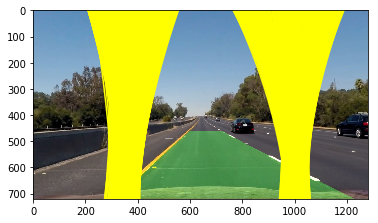

In [52]:
white_output = 'output_video/project_video_output_trial11_red_channel_all.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


In [53]:
##Code to Store video in frames

#import cv2
#vidcap = cv2.VideoCapture('./output_video/project_video_output_trial10_red_channel_all.mp4')
#success,image = vidcap.read()
#count = 0
#success = True
#while success:
#    success,image = vidcap.read()
#    print('Read a new frame: ', success)
#    cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
#    count += 1